In [1951]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import matplotlib.ticker as mtick
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, metrics
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [1952]:
df = pd.read_pickle("input/data_propre.pkl")

In [1953]:
pd.options.display.max_columns = None
df.head()

,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,LocationID,BankName,BankFDICNumber,BankStreet,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFY,FirstDisbursementDate,ProcessingMethod,Subprogram,TerminMonths,NAICSCode,NAICSDescription,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,LoanStatus,RevolverStatus,JobsSupported,CollateralInd
1,7A,COTTMAN TRANSMISSION,4210 RED BLUFF RD,PASADENA,TX,77503,262382.0,Loans from Old Closed Lenders,NaN,409 3rd Street S.W.,Washington,DC,20416,460400.0,345300.0,10/01/1999,2000,10/31/1999,Preferred Lenders Program,Guaranty,217,811113.0,Automotive Transmission Repair,HARRIS,TX,HOUSTON DISTRICT OFFICE,29.0,CORPORATION,1,0,12.0,Y
2,7A,GOSSELIN & SON TRUCKING INC,660 OLD FALL RIVER RD,NORTH DARTMOUTH,MA,2747,9551.0,"Bank of America, National Association",3510.0,100 North Tryon Street,Charlotte,NC,28255,36000.0,18000.0,10/01/1999,2000,10/31/1999,SBA Express Program,FA$TRK (Small Loan Express),36,NaN,NaN,BRISTOL,MA,MASSACHUSETTS DISTRICT OFFICE,9.0,CORPORATION,0,0,2.0,NaN
3,7A,Vande Hey Company Inc.,N2093 COUNTY ROAD N,APPLETON,WI,54915,75939.0,"Associated Bank, National Association",5296.0,200 N Adams St,GREEN BAY,WI,54301,100000.0,80000.0,10/01/1999,2000,11/30/1999,7a General,Guaranty,120,NaN,NaN,OUTAGAMIE,WI,WISCONSIN DISTRICT OFFICE,6.0,CORPORATION,0,0,0.0,N
4,7A,NORTHSTAR ANIMAL CLINIC PC,2004 BLACKBURN RD.,SACHSE,TX,75048,71616.0,LegacyTexas Bank,18843.0,PO Box 869111,Plano,TX,75024,151000.0,113250.0,10/01/1999,2000,12/31/1999,Preferred Lenders Program,Guaranty,84,235410.0,Masonry and Stone Contractors,DALLAS,TX,DALLAS / FT WORTH DISTRICT OFFICE,3.0,CORPORATION,0,0,3.0,NaN
5,7A,HOLLY INN PARTNERSHIP,153 AMPEY RD.,PAW PAW,MI,49079,58036.0,Fifth Third Bank,6672.0,38 Fountain Sq Plz,CINCINNATI,OH,45263,653000.0,489750.0,10/01/1999,2000,10/31/2000,Preferred Lenders Program,Guaranty,180,551112.0,Offices of Other Holding Companies,VAN BUREN,MI,MICHIGAN DISTRICT OFFICE,6.0,PARTNERSHIP,0,0,23.0,NaN


In [1954]:
df.shape

(1078960, 32)

In [1955]:
1078960-1059495

19465

In [1956]:
df = df.drop_duplicates(subset=["BorrName", "BorrStreet", "BorrCity", "FirstDisbursementDate"], keep="last")

In [1957]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1059495 entries, 1 to 331032
Data columns (total 32 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Program                1059495 non-null  object 
 1   BorrName               1059476 non-null  object 
 2   BorrStreet             1059485 non-null  object 
 3   BorrCity               1059495 non-null  object 
 4   BorrState              1059495 non-null  object 
 5   BorrZip                1059495 non-null  int64  
 6   LocationID             1058831 non-null  float64
 7   BankName               1059495 non-null  object 
 8   BankFDICNumber         968721 non-null   float64
 9   BankStreet             1058830 non-null  object 
 10  BankCity               1058831 non-null  object 
 11  BankState              1058828 non-null  object 
 12  BankZip                1058831 non-null  object 
 13  GrossApproval          1059495 non-null  float64
 14  SBAGuaranteedApproval  1

In [1958]:
df["ApprovalDate"]= pd.to_datetime(df["ApprovalDate"], errors='coerce')
df = df.set_index("ApprovalDate")

In [1959]:
df.index.min()

Timestamp('1999-10-01 00:00:00')

In [1960]:
df.index.max()

Timestamp('2025-07-02 00:00:00')

In [1961]:
df.columns

Index(['Program', 'BorrName', 'BorrStreet', 'BorrCity', 'BorrState', 'BorrZip',
       'LocationID', 'BankName', 'BankFDICNumber', 'BankStreet', 'BankCity',
       'BankState', 'BankZip', 'GrossApproval', 'SBAGuaranteedApproval',
       'ApprovalFY', 'FirstDisbursementDate', 'ProcessingMethod', 'Subprogram',
       'TerminMonths', 'NAICSCode', 'NAICSDescription', 'ProjectCounty',
       'ProjectState', 'SBADistrictOffice', 'CongressionalDistrict',
       'BusinessType', 'LoanStatus', 'RevolverStatus', 'JobsSupported',
       'CollateralInd'],
      dtype='object')

- Période des données : On a des contrats qui vont d'octobre 1990 à juillet 2025
- La colonne programme ne sert à rien ici sachant que les prêts dans cette table concernent toujours le même programme
- Les noms des entreprises ne vont pas servir non plus dans la modélisation (trop de noms à encoder et dans tout les cas trop de granularité), on doit aussi enlever l'adresse exacte, la ville (car on a le code postal)
- LocationID (SBA's unique lender ID code) ne sert à rien ici sachant qu'on a deja des variables liées
- BankStreet, BankCity, BankFDICNumber, Bankzip sont également à enlever (par contre on garde le nom de la banque mais à voir pour l'encodage car 4000 banques diff)
- NAICSDescription (variable textuelle donc à enlever ou traitement de texte à faire ?) en plus redondant avec NAICcode
- CongressionalDistrict à enlever car on a deja le 'state' et le "county" du projet
- Le reste à garder

In [1962]:
df = df.drop_duplicates()

In [1963]:
df = df.drop(columns={'Program',
                      'BorrName',
                      'BorrStreet',
                      'BorrCity',
                      'LocationID',
                      'BankFDICNumber',
                      'BankZip',
                      'BankStreet',
                      'BankCity',
                      'NAICSDescription',
                      'CongressionalDistrict',
                      "BorrZip"
})

In [1964]:
print(df.shape)
df.columns

(1059495, 19)


Index(['BorrState', 'BankName', 'BankState', 'GrossApproval',
       'SBAGuaranteedApproval', 'ApprovalFY', 'FirstDisbursementDate',
       'ProcessingMethod', 'Subprogram', 'TerminMonths', 'NAICSCode',
       'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'BusinessType',
       'LoanStatus', 'RevolverStatus', 'JobsSupported', 'CollateralInd'],
      dtype='object')

In [1965]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1059495 entries, 1999-10-01 to 2025-07-02
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   BorrState              1059495 non-null  object 
 1   BankName               1059495 non-null  object 
 2   BankState              1058828 non-null  object 
 3   GrossApproval          1059495 non-null  float64
 4   SBAGuaranteedApproval  1059495 non-null  float64
 5   ApprovalFY             1059495 non-null  int64  
 6   FirstDisbursementDate  1057627 non-null  object 
 7   ProcessingMethod       1059495 non-null  object 
 8   Subprogram             1059495 non-null  object 
 9   TerminMonths           1059495 non-null  int64  
 10  NAICSCode              1042746 non-null  float64
 11  ProjectCounty          1059495 non-null  object 
 12  ProjectState           1059495 non-null  object 
 13  SBADistrictOffice      1059495 non-null  object 
 14  Bus

In [1966]:
# Mise au format date
df["FirstDisbursementDate"] = pd.to_datetime(df["FirstDisbursementDate"])

### Traitement des valeurs manquantes

#### A) Variables numériques

In [1967]:
# Pas de valeurs manquantes pour les variables numériques
col_numericals = ["GrossApproval", "SBAGuaranteedApproval", "TerminMonths", "JobsSupported"]
df[col_numericals].isna().sum()

GrossApproval            0
SBAGuaranteedApproval    0
TerminMonths             0
JobsSupported            0
dtype: int64

#### B) Variables restantes

In [1968]:
col_restants = [col for col in df.columns if col not in col_numericals]
df[col_restants].isna().sum()

BorrState                    0
BankName                     0
BankState                  667
ApprovalFY                   0
FirstDisbursementDate     1868
ProcessingMethod             0
Subprogram                   0
NAICSCode                16749
ProjectCounty                0
ProjectState                 0
SBADistrictOffice            0
BusinessType                 0
LoanStatus                   0
RevolverStatus               0
CollateralInd            85031
dtype: int64

In [1969]:
# On voit que lorsque Bankstate est manquant on a MISSINGMAINBANKID comme nom de banque (inconnu)
df.loc[df["BankState"].isna()]

# On va donc imputer ces valeurs dans une catégorie "unknown"
df["BankName"] = np.where(df["BankName"]=="MISSINGMAINBANKID", "unknown", df["BankName"])
df["BankState"] = np.where(df["BankState"].isna(), "unknown", df["BankState"])
print(f'Nombre de lignes imputées {df[df["BankState"] == "unknown"].shape[0]}')

Nombre de lignes imputées 667


In [1970]:
# Les lignes ou FirstDisbursementDate est manquant les autres variables sont renseignées
df.loc[df['FirstDisbursementDate'].isna()]
# Sachant que le premier versement arrive après un certain temps de la date d'approbation on peut prendre la médiane (dans tout les cas ca n'aura pas un grand impact car peu de valeurs manquantes)
approval_dates = df.index.to_series()
delai_median = (df['FirstDisbursementDate'] - approval_dates).median()
valeurs_remplacement = approval_dates + delai_median
df['FirstDisbursementDate'] = df['FirstDisbursementDate'].fillna(valeurs_remplacement)

In [1971]:
# Pour la variable CollateralInd on a deux possibilités (oui/non), pour povuoir garder la variable on fait l'hypothèse que NaN = No
df["CollateralInd"]=df["CollateralInd"].fillna(0)
df["CollateralInd"] = np.where(df['CollateralInd'] == "Y", 1, 0)
df.CollateralInd.value_counts()

CollateralInd
0    638905
1    420590
Name: count, dtype: int64

In [1972]:
# Seule possibilité est d'imputer par 'inconnu' pour NAICSCode
df["NAICSCode"] = df["NAICSCode"].fillna("inconnu")

### Analyse des variables numériques

In [1973]:
# Variables quanti
df_num = df[col_numericals]

In [1974]:
df_num.describe().round(3)

,GrossApproval,SBAGuaranteedApproval,TerminMonths,JobsSupported
count,1059495.000,1059495.000,1059495.000,1059495.000
mean,255927.729,187750.704,103.539,9.033
std,504655.518,389086.347,72.156,24.773
min,55.000,46.750,0.000,0.000
25%,25300.000,15000.000,60.000,1.000
50%,80000.000,50000.000,84.000,4.000
75%,250000.000,175000.000,120.000,10.000
max,5000000.000,4500000.000,569.000,9500.000


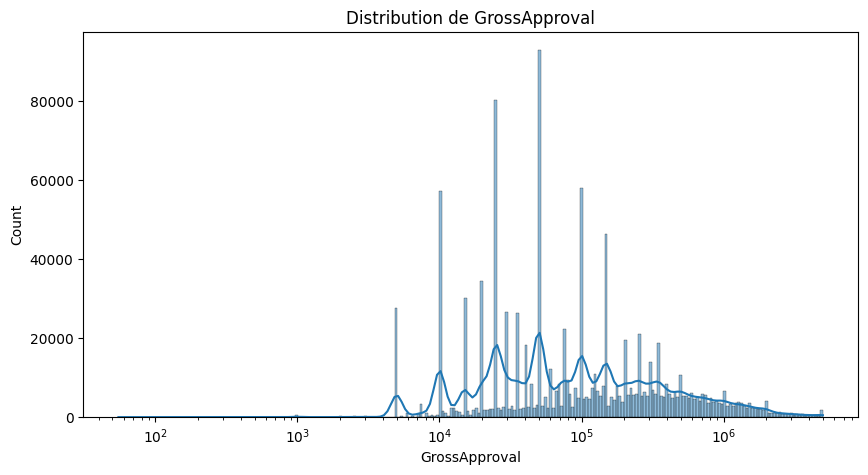

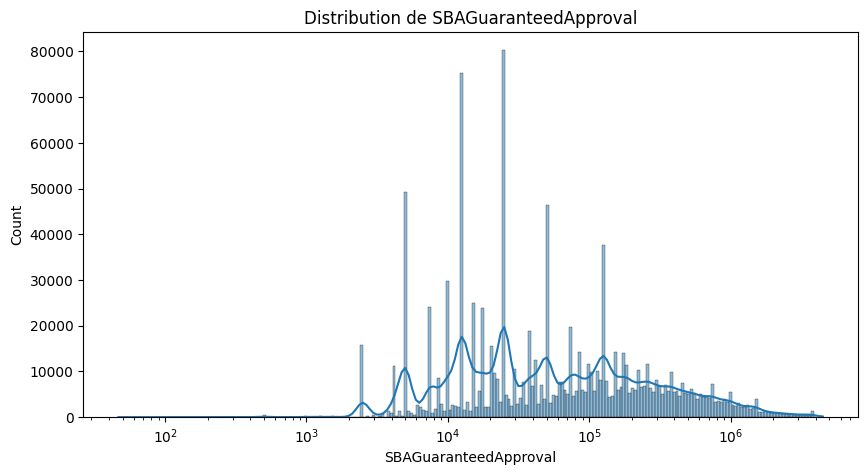

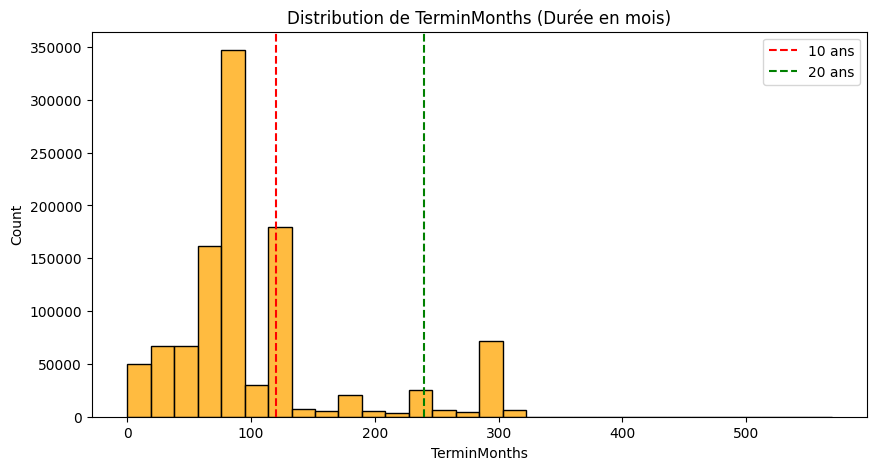

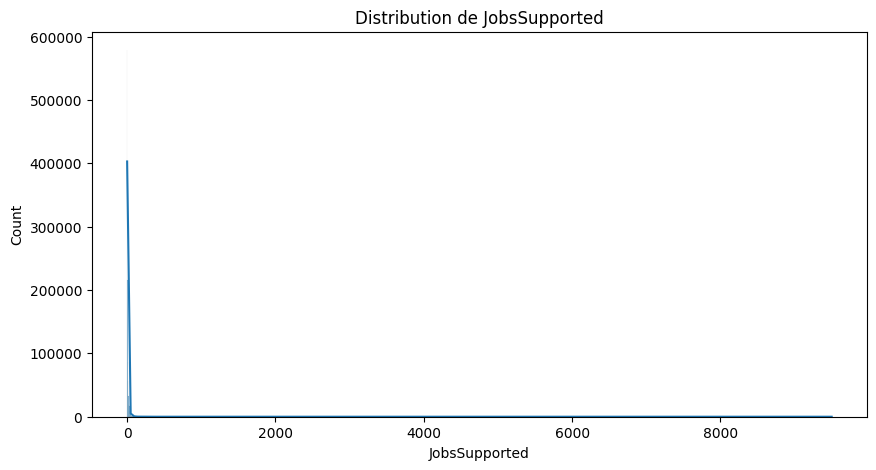

In [1975]:
#Visualisation graphique
for col in df_num.columns:
    plt.figure(figsize=(10, 5))

    if "Approval" in col:
        sns.histplot(data=df, x=col, kde=True, log_scale=True)
        plt.title(f"Distribution de {col}")
        
    elif "Termin" in col:
        sns.histplot(data=df, x=col, kde=False, bins=30, color='orange')
        plt.title(f"Distribution de {col} (Durée en mois)")
        plt.axvline(x=120, color='r', linestyle='--', label='10 ans') # 120 mois
        plt.axvline(x=240, color='g', linestyle='--', label='20 ans') # 240 mois
        plt.legend()
    else:
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f"Distribution de {col}")

    plt.show()

- On voit qu'on a surtout à faire à des petites entreprises au vu de la distribution des emploi crées
- Les montants prêtés et garantis ont des distributions assez proches
- On a surtout à faire à des prêts de moins de 10 ans 

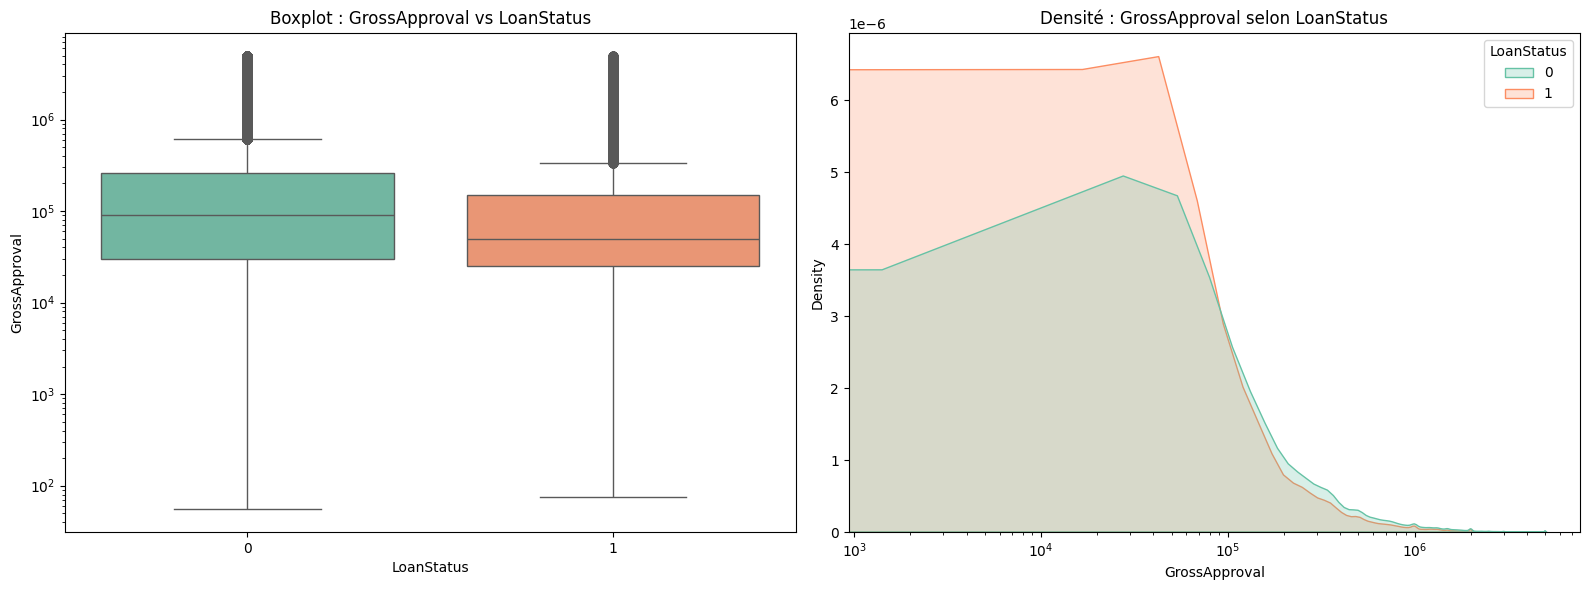

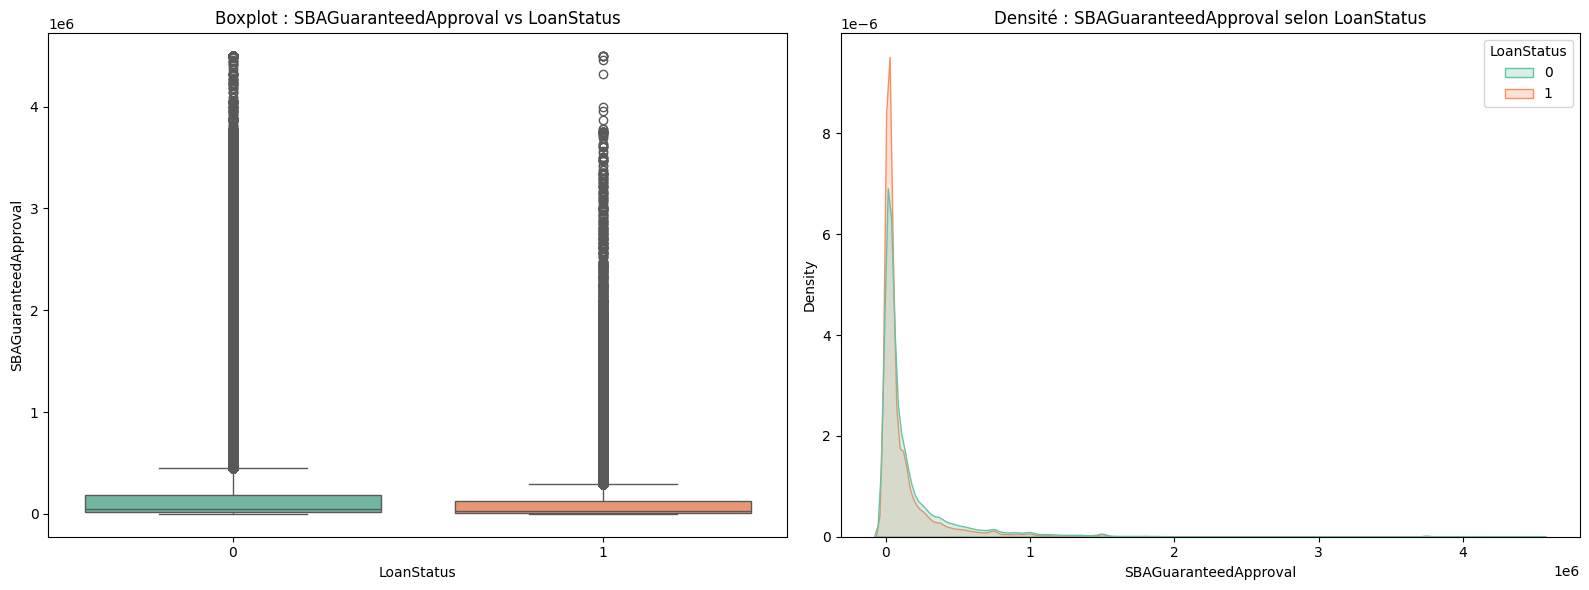

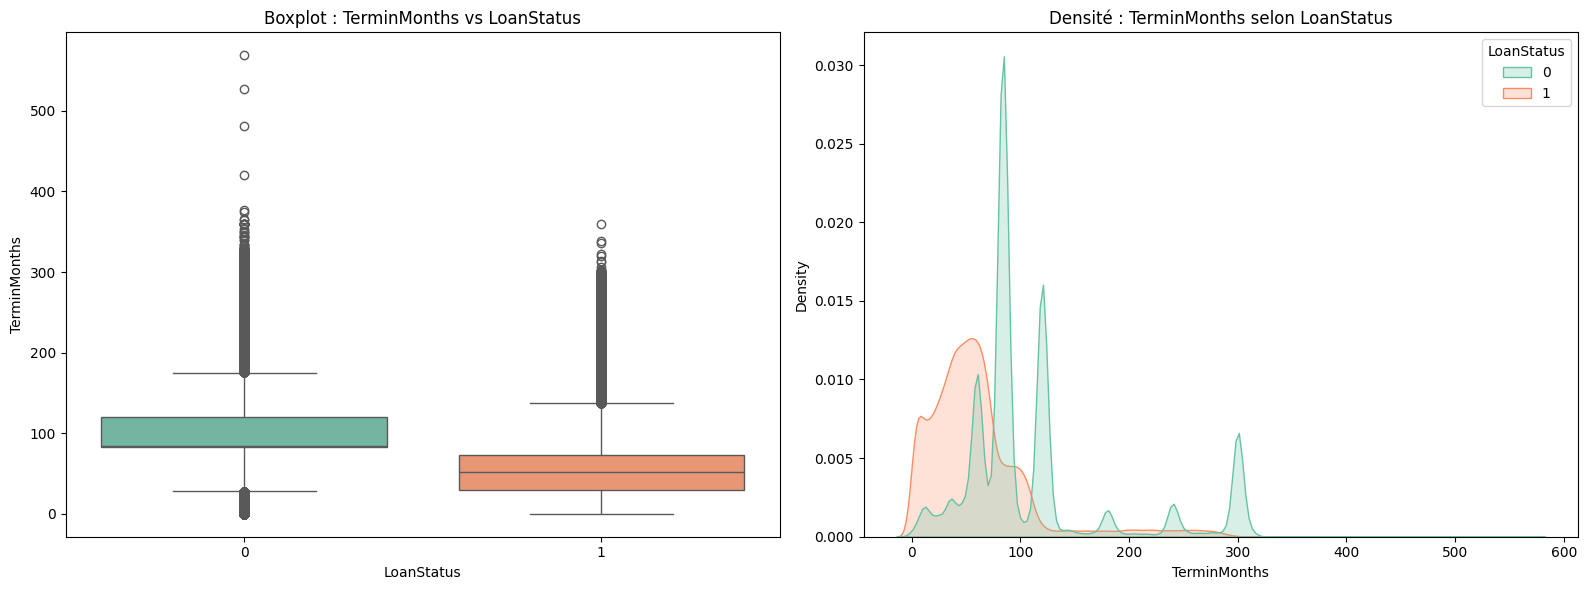

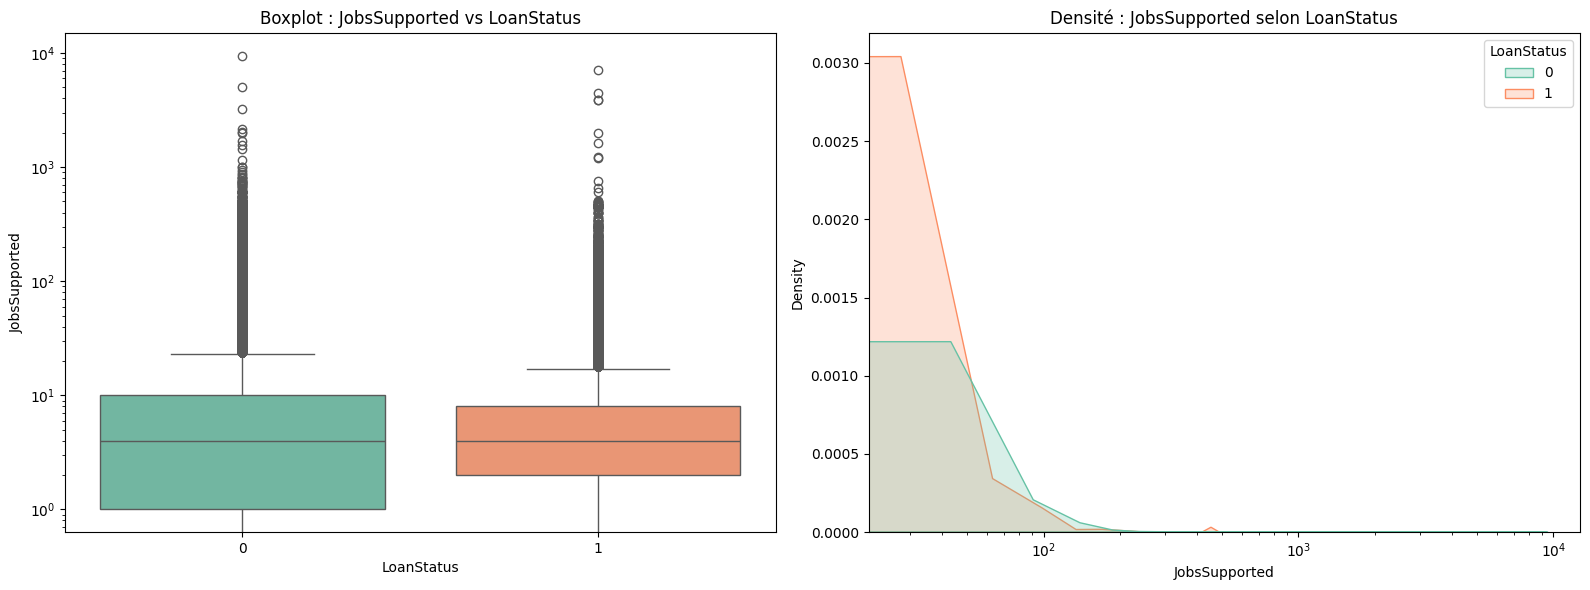

In [1976]:
# Visualisation en fonction de la cible
for col in df_num.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.boxplot(
        data=df, 
        x='LoanStatus', 
        y=col, 
        hue='LoanStatus',  
        legend=False,    
        ax=axes[0], 
        palette="Set2"
    )
    axes[0].set_title(f"Boxplot : {col} vs LoanStatus")
    

    if col in ['GrossApproval', 'JobsSupported']:
        axes[0].set_yscale('log')
    
    sns.kdeplot(
        data=df, 
        x=col, 
        hue='LoanStatus', 
        fill=True, 
        common_norm=False, 
        ax=axes[1], 
        palette="Set2"
    )
    axes[1].set_title(f"Densité : {col} selon LoanStatus")
    
    if col in ['GrossApproval', 'JobsSupported']:
        axes[1].set_xscale('log')

    plt.tight_layout()
    plt.show()

### Analayse de la variable cible dans le temps

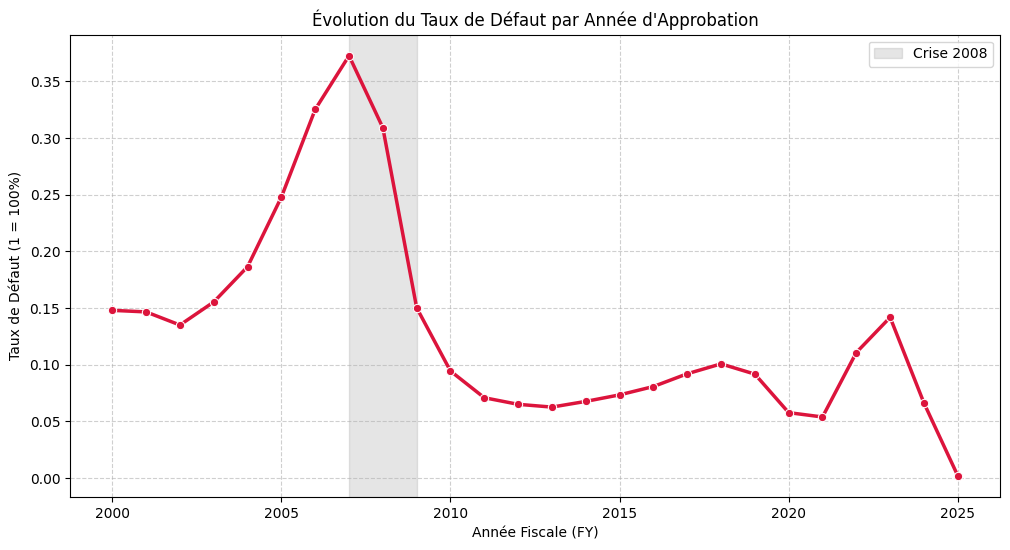

In [1977]:
defaut_par_an = df.groupby('ApprovalFY')['LoanStatus'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=defaut_par_an, marker='o', color='crimson', linewidth=2.5)

plt.title("Évolution du Taux de Défaut par Année d'Approbation")
plt.ylabel("Taux de Défaut (1 = 100%)")
plt.xlabel("Année Fiscale (FY)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.axvspan(2007, 2009, color='gray', alpha=0.2, label='Crise 2008')
plt.legend()
plt.show()

- On voit graphiquement que de manière logique on a un pic des faillites en sur la période de la crise de 2008
- Il semble également y avoir un pic retardé de l'effet de la crise covid
- A voir si on garde la période de 2008 sachant que ca peut ajouter du bruit inutile dans le modèle (peutetre mettre une indicatrice des périodes de crise)
- On a une chute assez importante sur la dernière période (pas assez de données ?)

### Analyse des variables non numériques

In [1978]:
df["BusinessType"] = np.where(df["BusinessType"]== " ", "unknown", df["BusinessType"])
df.BusinessType.value_counts()
# On supprime les lignes ou on n'a pas de business type

BusinessType
CORPORATION    838006
INDIVIDUAL     196159
PARTNERSHIP     24872
                  458
Name: count, dtype: int64

In [1979]:
df = df.loc[df["BusinessType"].isin(["CORPORATION", "INDIVIDUAL", "PARTNERSHIP"])]
df.BusinessType.value_counts()

BusinessType
CORPORATION    838006
INDIVIDUAL     196159
PARTNERSHIP     24872
Name: count, dtype: int64

*Pour la variable NAICS code on peut trouver le secteur d'activité de l'entreprise à partir des deux premiers chiffres (permettra de différencier le risque selon le secteur)*

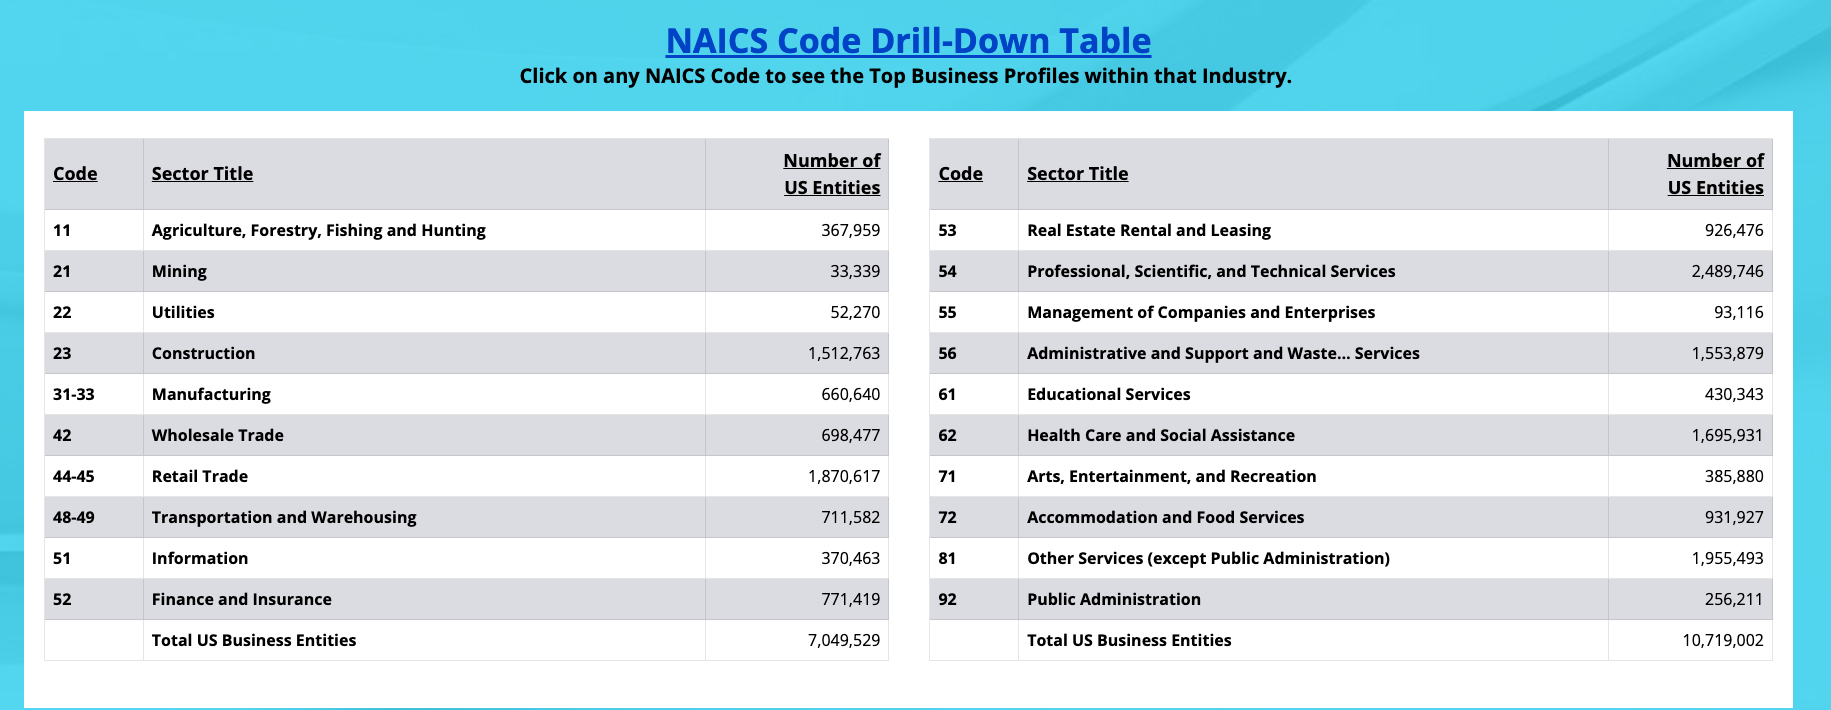

In [1980]:
# Dictionnaire pour relier le cdes premiers chifres du code NAIC selon le secteur (voir image dessus)
naics_map = {
    '11': 'Agriculture', '21': 'Mining', '22': 'Utilities', '23': 'Construction',
    '31': 'Manufacturing', '32': 'Manufacturing', '33': 'Manufacturing',
    '42': 'Wholesale', '44': 'Retail', '45': 'Retail',
    '48': 'Transport', '49': 'Transport', '51': 'Information',
    '52': 'Finance', '53': 'Real Estate', '54': 'Prof. Services',
    '55': 'Management', '56': 'Admin/Waste', '61': 'Education',
    '62': 'Health Care', '71': 'Arts/Entertainment', '72': 'Accommodation/Food',
    '81': 'Other Services', '92': 'Public Admin', "in": "Inconnu"
}

# On prend les deux premiers chiffres
df['Industry'] = df['NAICSCode'].astype(str).str[:2]

# On fait le mapping du dico
df['IndustryName'] = df['Industry'].map(naics_map).fillna(df['Industry'])

# On calcule le taux de défaut par industrie
industry_risk = df.groupby('IndustryName')['LoanStatus'].mean().sort_values(ascending=False)

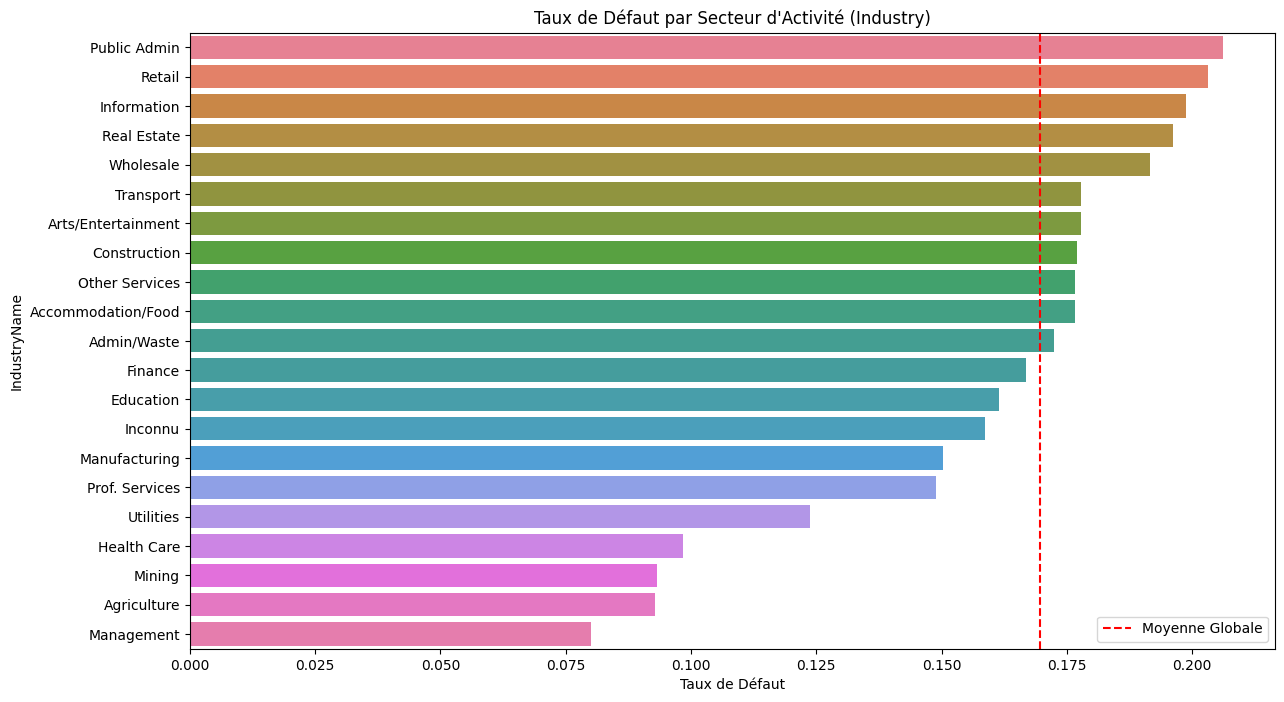

In [1981]:
plt.figure(figsize=(14, 8))
sns.barplot(x=industry_risk.values, 
            y=industry_risk.index, 
            hue=industry_risk.index)
plt.title("Taux de Défaut par Secteur d'Activité (Industry)")
plt.xlabel("Taux de Défaut")
plt.axvline(x=df['LoanStatus'].mean(), color='r', linestyle='--', label='Moyenne Globale')
plt.legend()
plt.show()

On voit bien graphiquement que le risque dépend fortement du secteur d'activité avec des secteurs plus risquées que d'autres. Mais il faut faire aussi attention à la significativité de ces chiffres dans l'intérprétation.

In [1982]:
# ON voit qu'on a des secteurs qui sont tr!s faiblement représentés
df.IndustryName.value_counts()

IndustryName
Retail                169385
Accommodation/Food    128179
Construction          105177
Prof. Services        102936
Other Services        100298
Manufacturing          84307
Health Care            83130
Wholesale              59113
Admin/Waste            52919
Transport              47126
Arts/Entertainment     25283
Real Estate            22768
Finance                17575
Inconnu                16682
Information            15368
Education              12892
Agriculture            11870
Mining                  2480
Utilities                930
Management               425
Public Admin             194
Name: count, dtype: int64

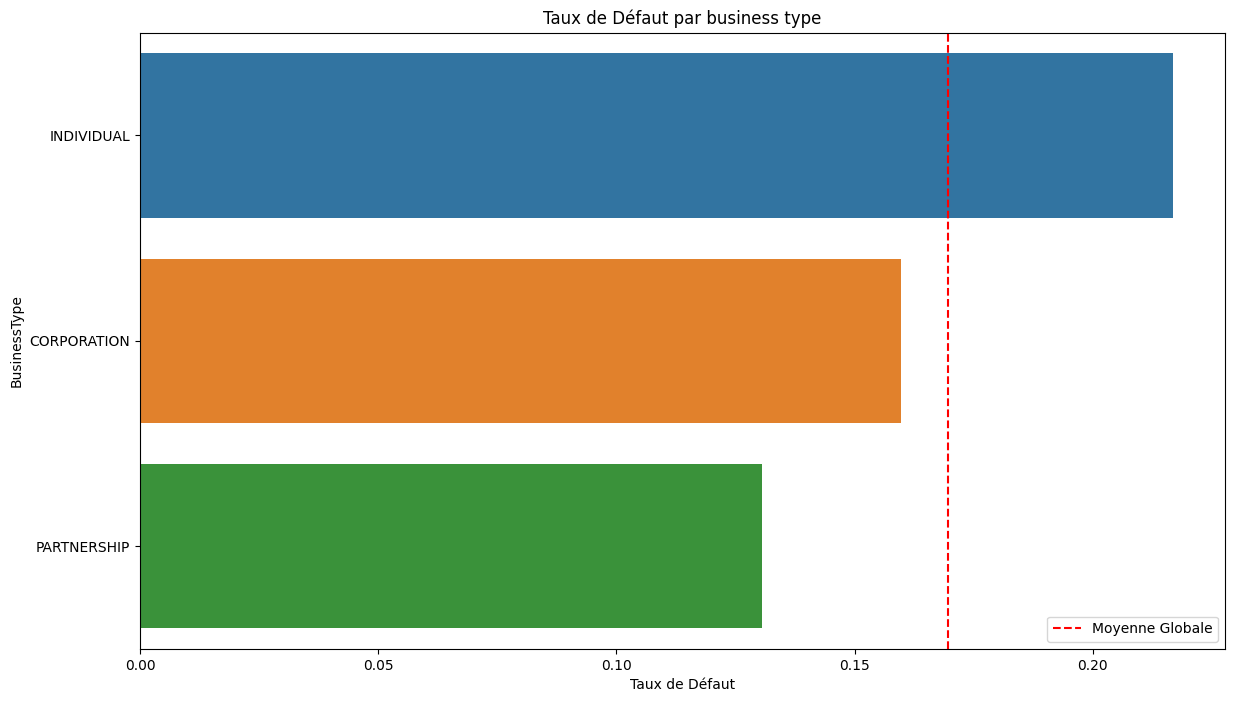

In [1983]:
# Taux de défaut selon le businesstype (individuel, corpo, partnership)
business_risk = df.groupby('BusinessType')['LoanStatus'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(x=business_risk.values, 
            y=business_risk.index, 
            hue=business_risk.index)
plt.title("Taux de Défaut par business type")
plt.xlabel("Taux de Défaut")
plt.axvline(x=df['LoanStatus'].mean(), color='r', linestyle='--', label='Moyenne Globale')
plt.legend()
plt.show()

La encore on voit que la variable permet de bien différencier le risque, les entreprises individuels semblent bcp plus risquées que les autres types de boites

/var/folders/48/gm8qnf514r3bs39xcscgqymr0000gn/T/ipykernel_87098/3523158129.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


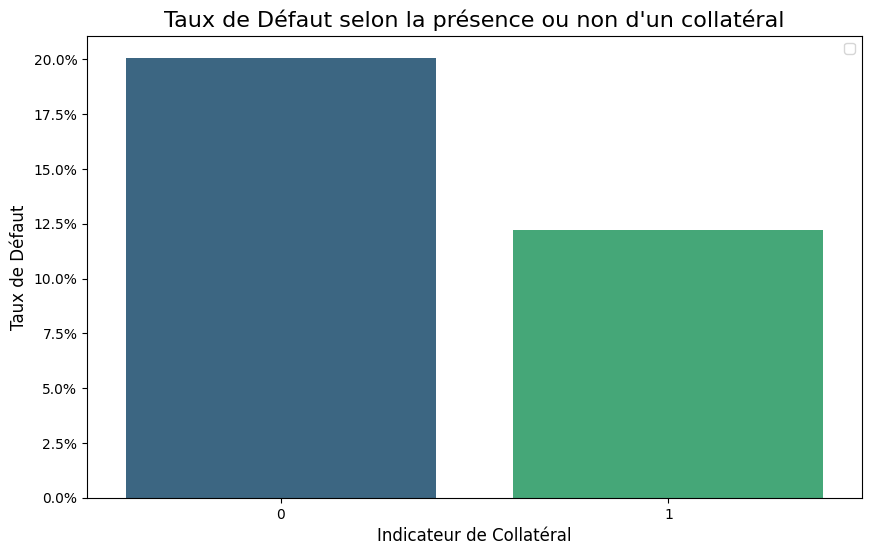

In [1984]:
collat_risk = df.groupby('CollateralInd')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6)) # Format un peu plus compact pour des barres verticales
sns.barplot(x=collat_risk.index, 
            y=collat_risk.values, 
            hue=collat_risk.index, 
            legend=False, 
            palette="viridis")

plt.title("Taux de Défaut selon la présence ou non d'un collatéral", fontsize=16)
plt.xlabel("Indicateur de Collatéral", fontsize=12)
plt.ylabel("Taux de Défaut", fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.show()

Les prêts sans collatéral sont logiquement plus risqués

#### Variables géographiques

In [1985]:
round(df["BorrState"].value_counts(), 5)
# On voit qu'il y des régions avec trop peu d'observations (à voir s'il ne faut pas les regrouper)

BorrState
CA    139267
TX     80789
NY     69885
FL     54337
OH     47626
PA     41114
IL     34903
MA     34520
MI     33741
NJ     31495
MN     29062
GA     27521
WA     27338
WI     25144
CO     24650
UT     23579
AZ     22582
IN     20224
MO     19878
NC     18886
MD     16279
VA     15991
OR     14348
CT     13975
NH     12022
TN     10387
PR     10378
ID     10369
OK     10067
KY      9300
LA      9254
KS      9230
IA      9111
RI      9093
NV      8949
MS      8659
SC      7663
NE      6977
AL      6964
ME      6444
MT      6296
AR      5949
NM      5194
HI      5106
VT      4424
ND      4114
SD      3046
WV      3003
DE      2802
WY      2151
DC      2001
AK      1858
GU       815
VI       234
MP        20
AS        11
PW         6
MH         3
AE         2
FM         1
Name: count, dtype: int64

On a des états avec un nb d'obs très faible,  Je pense il faut regrouper lrsq le nb  d'obs de l'etat est inf à 100

In [1986]:
# ON fait le choix de regrouper à partir de VI dans une catégorie Other
freq = df['BorrState'].value_counts()
state_rares = freq[freq < 239].index
df.loc[df['BorrState'].isin(state_rares), 'BorrState'] = 'Other'

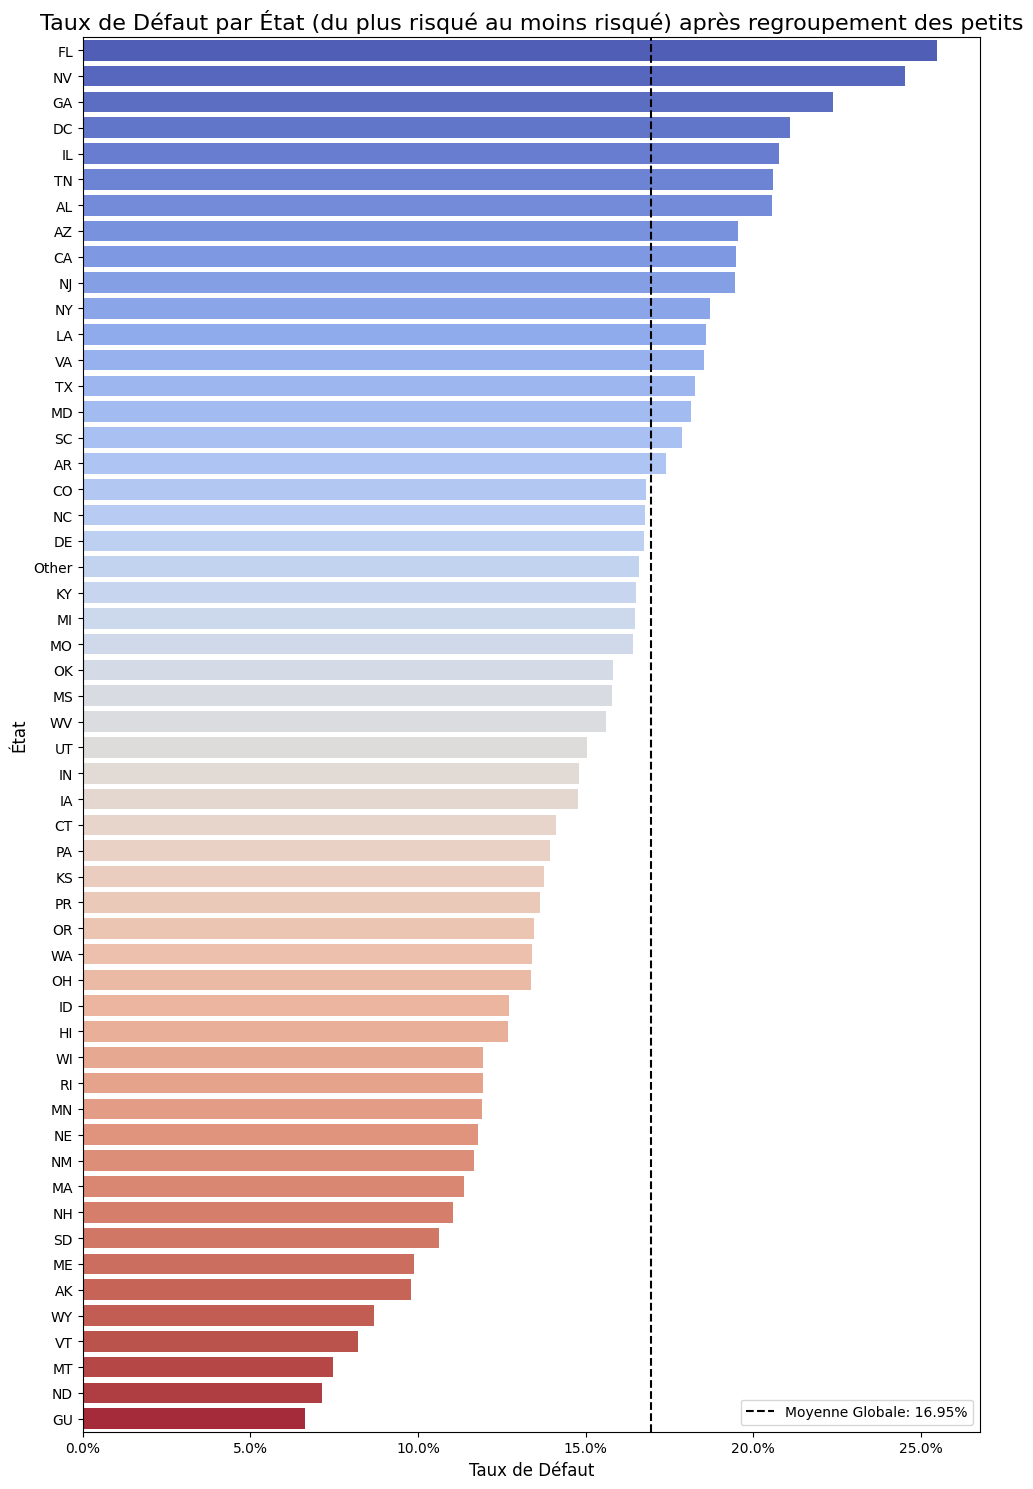

In [1987]:
state_risk = df.groupby('BorrState')['LoanStatus'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 15)) 
sns.barplot(x=state_risk.values, 
            y=state_risk.index, 
            hue=state_risk.index, 
            legend=False, 
            palette="coolwarm")

plt.title("Taux de Défaut par État (du plus risqué au moins risqué) après regroupement des petits", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

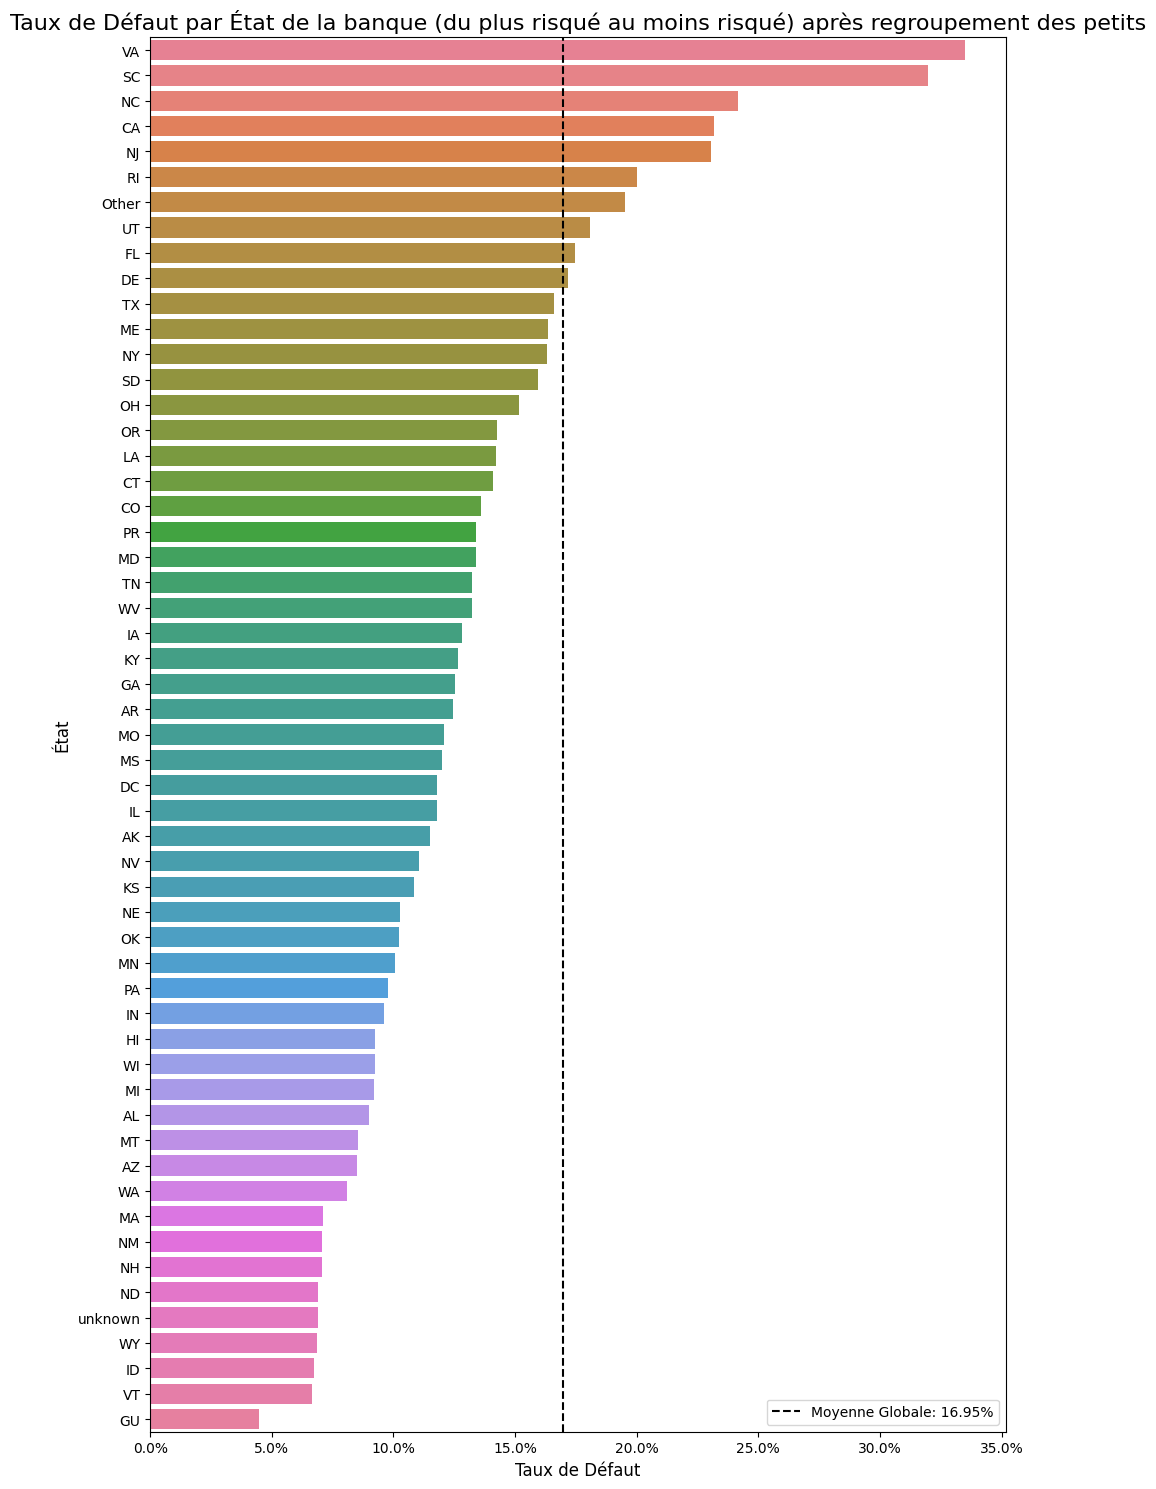

In [1988]:
freq = df['BankState'].value_counts()
state_rares = freq[freq < 400].index
df.loc[df['BankState'].isin(state_rares), 'BankState'] = 'Other'

bank_state_risk = df.groupby('BankState')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=bank_state_risk.values, 
            y=bank_state_risk.index, 
            hue=bank_state_risk.index, 
            legend=False)

plt.title("Taux de Défaut par État de la banque (du plus risqué au moins risqué) après regroupement des petits", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

La aussi on voit que selon l'état de la banque on a des taux de défaut très différent

In [1989]:
df.ProcessingMethod.value_counts()

ProcessingMethod
SBA Express Program                                             556722
Preferred Lenders Program                                       266712
7a General                                                       82719
Community Express                                                42876
Low Documentation Program                                        41874
Small Loan Advantage Initiative                                  24171
Patriot Express Loans                                             9398
Certified Lenders Program                                         9313
Community Advantage Initiative                                    4478
International Trade Loans                                         4068
Rural Loan Initiative                                             3616
Gulf Opportunity Pilot Loan Program                               2771
Standard Asset Base Working Capital Line of Credit (CAPLine)      2655
Export Express                                              

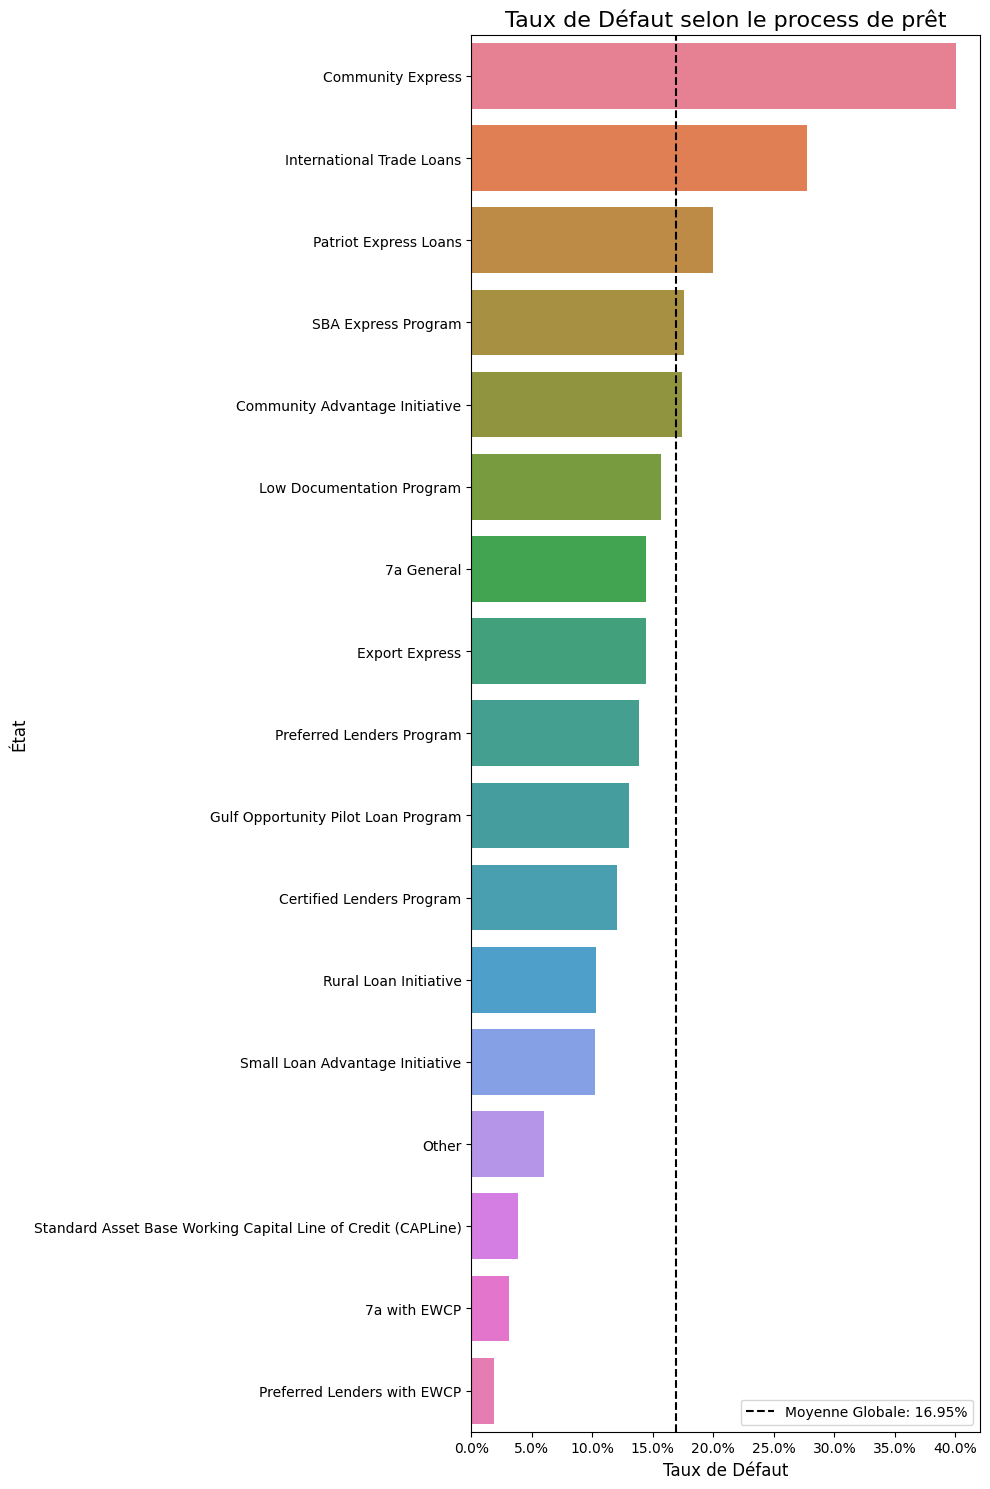

In [1990]:
freq = df['ProcessingMethod'].value_counts()
rares = freq[freq < 1000].index
df.loc[df['ProcessingMethod'].isin(rares), 'ProcessingMethod'] = 'Other'
method_risk = df.groupby('ProcessingMethod')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=method_risk.values, 
            y=method_risk.index, 
            hue=method_risk.index, 
            legend=False)

plt.title("Taux de Défaut selon le process de prêt", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

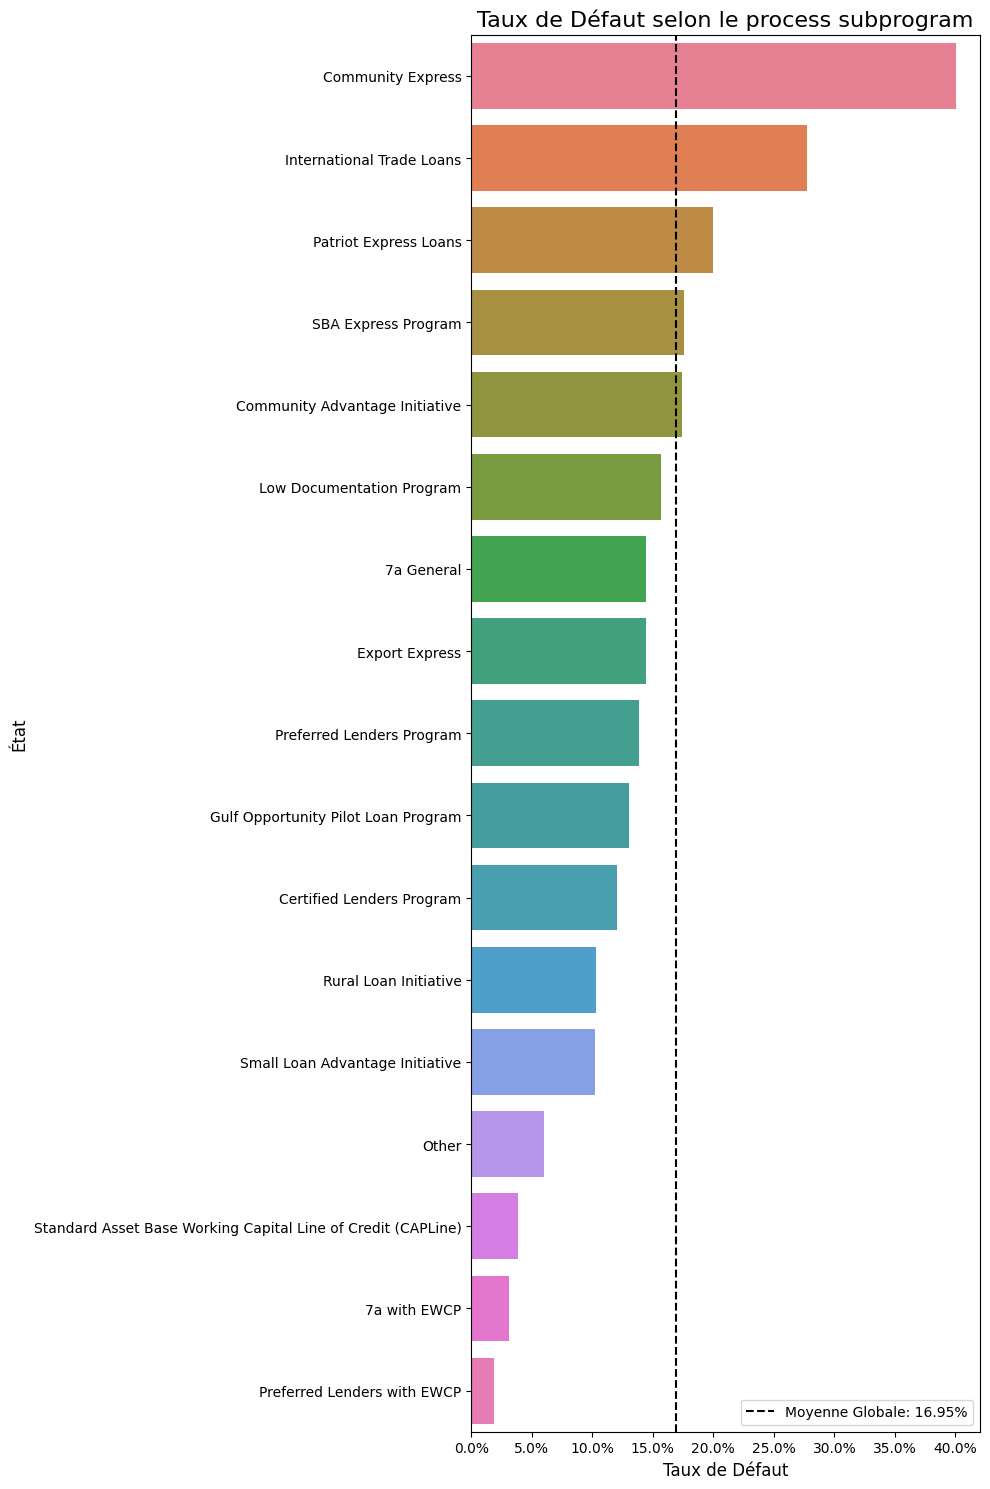

In [1991]:
freq = df['Subprogram'].value_counts()
rares = freq[freq < 1000].index
df.loc[df['ProcessingMethod'].isin(rares), 'Subprogram'] = 'Other'
method_risk = df.groupby('ProcessingMethod')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=method_risk.values, 
            y=method_risk.index, 
            hue=method_risk.index, 
            legend=False)

plt.title("Taux de Défaut selon le process subprogram", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

In [1992]:
# Taux de défaut selon RevolverStatus
pd.crosstab(df["RevolverStatus"], df["LoanStatus"], normalize="index")

LoanStatus,0,1
RevolverStatus,,
0,0.835366,0.164634
1,0.819437,0.180563


In [1993]:
# Matrice de corrélation

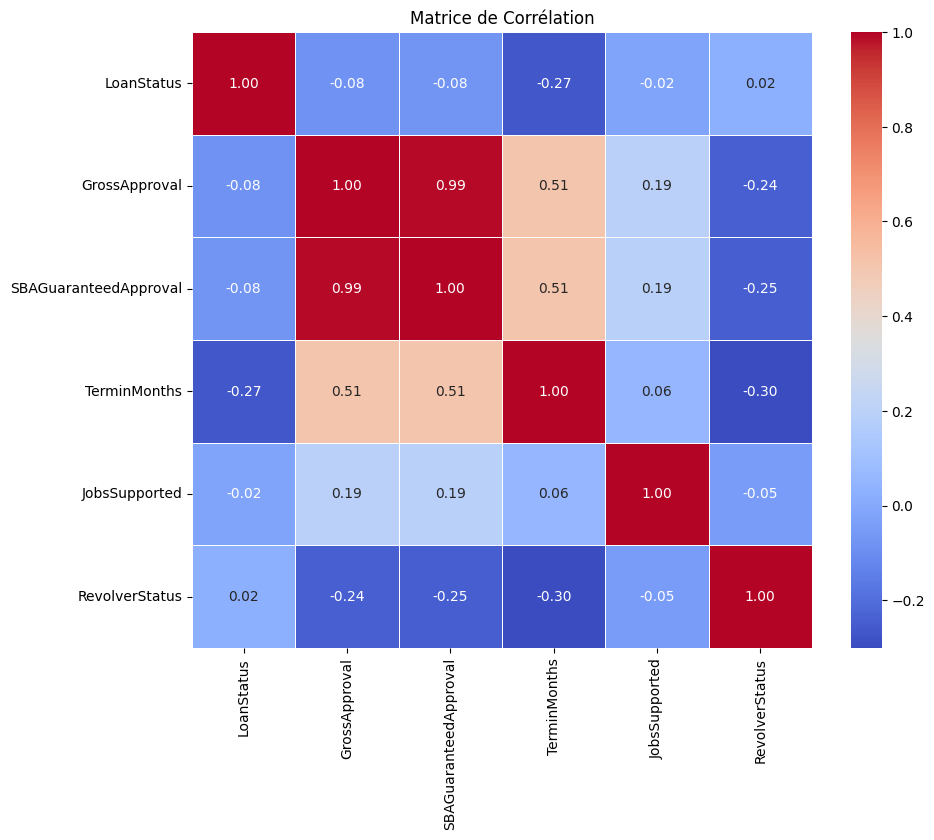

In [1994]:
cols_corr = ['LoanStatus', 'GrossApproval', 'SBAGuaranteedApproval', 'TerminMonths', 'JobsSupported', 'RevolverStatus']
corr_matrix = df[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

## Feature engineering

#### A. Outliers sur les variables quanti

 Au lieu de supprimer les outliers (qui sont porteurs d'information dans ce cadre surtout qu'on en a bcp au vu des boxplot qu'on a vu au dessus) on va plutot faire une transformation logarithmique permettant d'attenuer l'effet des outliers

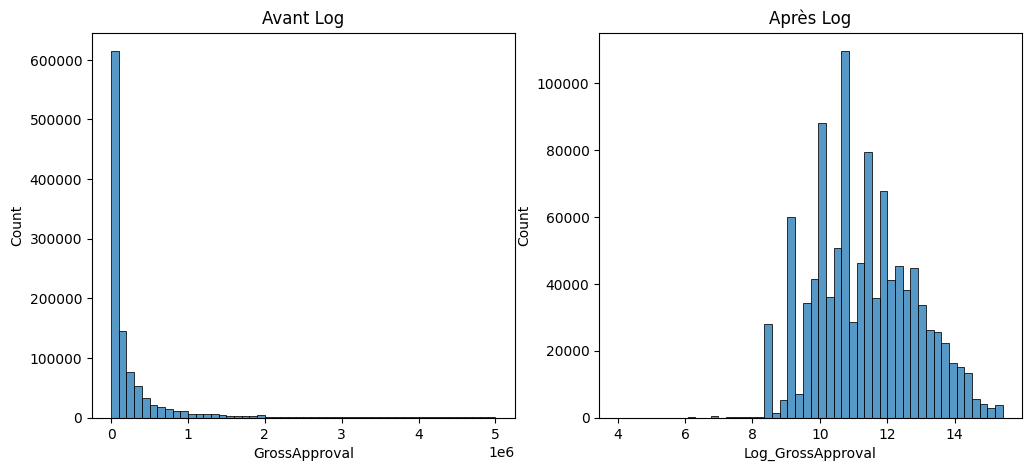

In [1995]:
df['Log_GrossApproval'] = np.log1p(df['GrossApproval'])
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['GrossApproval'], ax=ax[0], bins=50).set_title("Avant Log")
sns.histplot(df['Log_GrossApproval'], ax=ax[1], bins=50).set_title("Après Log")
plt.show()

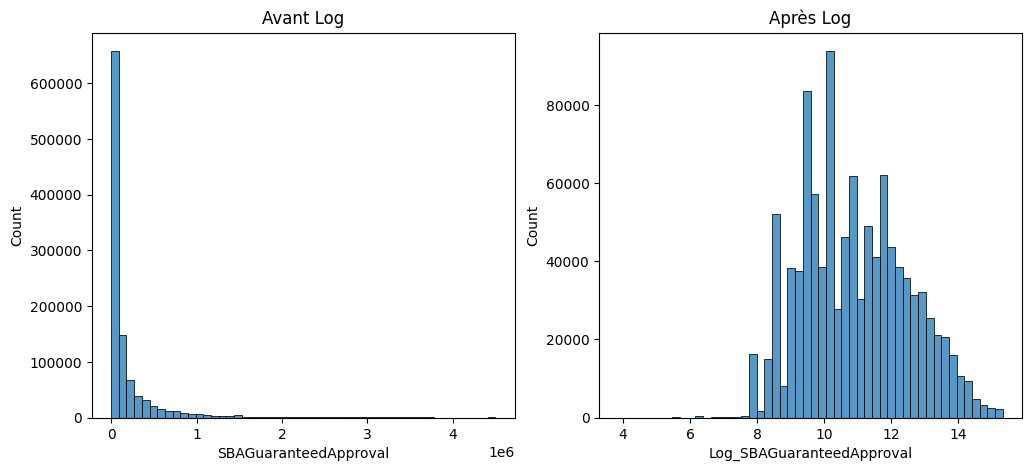

In [1996]:
df['Log_SBAGuaranteedApproval'] = np.log1p(df['SBAGuaranteedApproval'])
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['SBAGuaranteedApproval'], ax=ax[0], bins=50).set_title("Avant Log")
sns.histplot(df['Log_SBAGuaranteedApproval'], ax=ax[1], bins=50).set_title("Après Log")
plt.show()

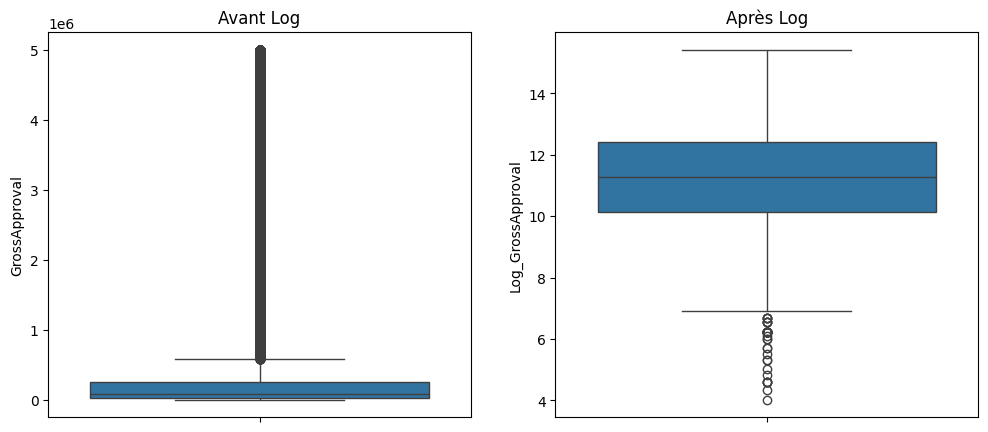

In [1997]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(df['GrossApproval'], ax=ax[0]).set_title("Avant Log")
sns.boxplot(df['Log_GrossApproval'], ax=ax[1]).set_title("Après Log")
plt.show()

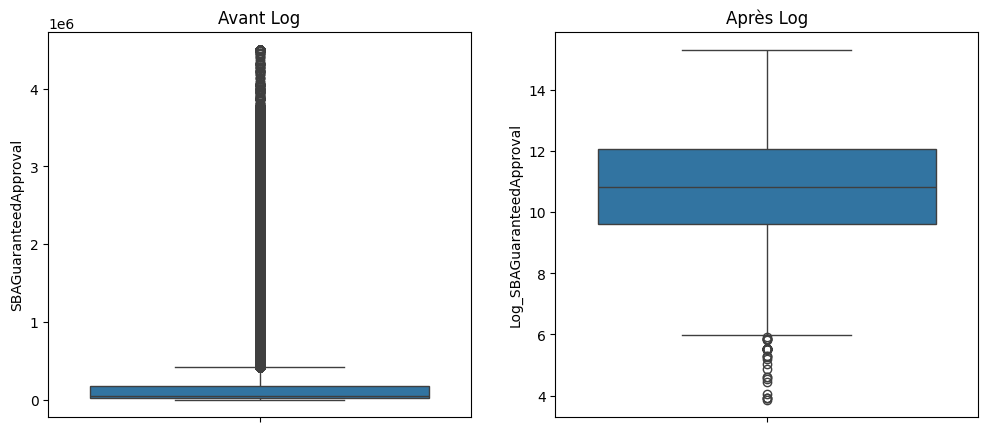

In [1998]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(df['SBAGuaranteedApproval'], ax=ax[0]).set_title("Avant Log")
sns.boxplot(df['Log_SBAGuaranteedApproval'], ax=ax[1]).set_title("Après Log")
plt.show()

In [1999]:
# Les contrats ou on a 0 temps restants
df = df[df["TerminMonths"]!=0]
df['TerminMonths_cut'] = pd.qcut(df["TerminMonths"], q=20, duplicates ='drop')

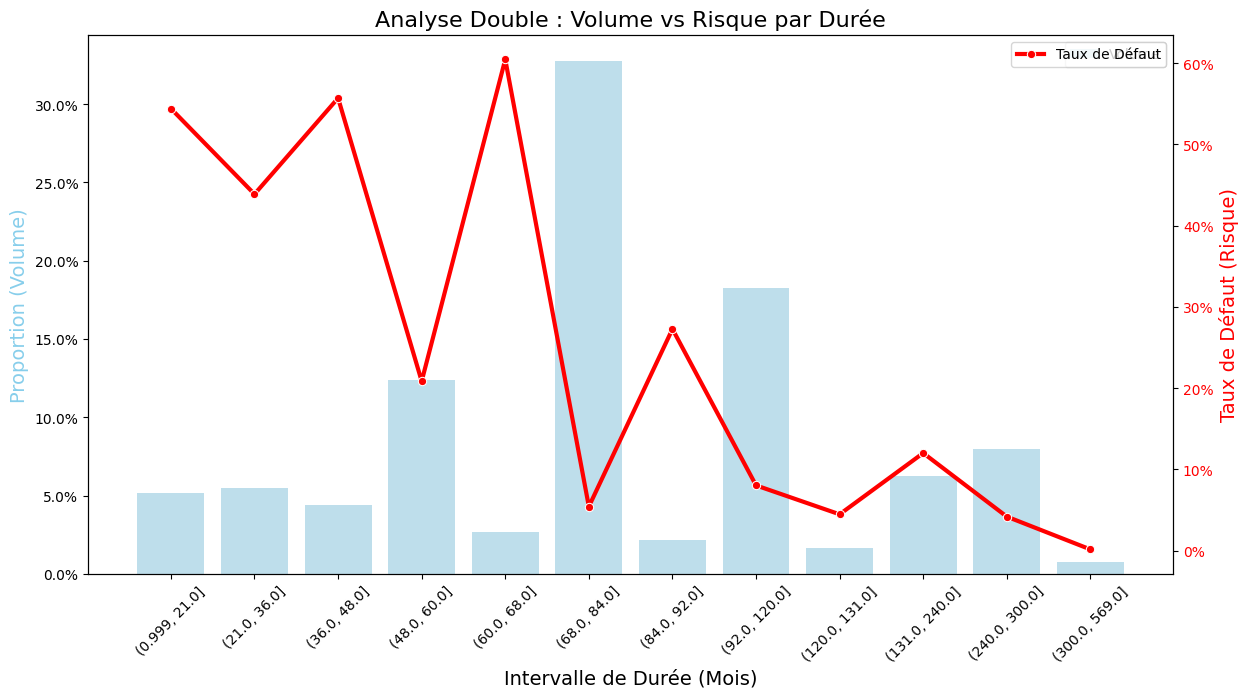

In [2000]:
volume = df['TerminMonths_cut'].value_counts(normalize=True).sort_index()
volume.index = volume.index.astype(str) # <--- LA CORRECTION EST ICI

risk = df.groupby('TerminMonths_cut', observed=False)['LoanStatus'].mean().sort_index()
risk.index = risk.index.astype(str)     # <--- ET ICI

fig, ax1 = plt.subplots(figsize=(14, 7))


sns.barplot(x=volume.index, y=volume.values, ax=ax1, color='skyblue', alpha=0.6, label='Volume')
ax1.set_ylabel("Proportion (Volume)", fontsize=14, color='skyblue')
ax1.set_xlabel("Intervalle de Durée (Mois)", fontsize=14)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2 = ax1.twinx()

sns.lineplot(x=risk.index, y=risk.values, ax=ax2, color='red', marker='o', linewidth=3, label='Taux de Défaut')

ax2.set_ylabel("Taux de Défaut (Risque)", fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title("Analyse Double : Volume vs Risque par Durée", fontsize=16)
ax1.tick_params(axis='x', rotation=45) # Rotation des étiquettes

plt.show()

In [2001]:
bins_cut = [0, 48, 68, 84, 120, 240, 600] # On est obligé de regrouper 60-68 avec la catégorie précédante car pas assez d'obs mais très diff 

df['TerminMonths_cut'] = pd.cut(df['TerminMonths'], bins=bins_cut)
df['TerminMonths_cut'].value_counts(normalize=True)

TerminMonths_cut
(68, 84]      0.327826
(84, 120]     0.204354
(0, 48]       0.150937
(48, 68]      0.150635
(240, 600]    0.087210
(120, 240]    0.079037
Name: proportion, dtype: float64

In [2002]:
df.groupby('TerminMonths_cut').agg({'LoanStatus' : "mean"})

/var/folders/48/gm8qnf514r3bs39xcscgqymr0000gn/T/ipykernel_87098/1342425714.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('TerminMonths_cut').agg({'LoanStatus' : "mean"})


,LoanStatus
TerminMonths_cut,
"(0, 48]",0.509353
"(48, 68]",0.279497
"(68, 84]",0.054225
"(84, 120]",0.100540
"(120, 240]",0.104406
"(240, 600]",0.038477


In [2003]:
df["JobsSupported_cut"] = pd.qcut(df["JobsSupported"], q=20, duplicates='drop')

In [2004]:
df.groupby("JobsSupported_cut").agg({"LoanStatus" : "mean",
                                    "JobsSupported" : "count"})

/var/folders/48/gm8qnf514r3bs39xcscgqymr0000gn/T/ipykernel_87098/2790225200.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("JobsSupported_cut").agg({"LoanStatus" : "mean",


,LoanStatus,JobsSupported
JobsSupported_cut,,
"(-0.001, 1.0]",0.154380,287627
"(1.0, 2.0]",0.176628,120672
"(2.0, 3.0]",0.200156,85973
"(3.0, 4.0]",0.193024,83492
"(4.0, 5.0]",0.197073,63824
"(5.0, 6.0]",0.189410,56222
"(6.0, 8.0]",0.184717,73729
"(8.0, 10.0]",0.169622,57410
"(10.0, 12.0]",0.169068,37902


In [2005]:
bins_jobs = [-0.001, 2, 3, 8, 10, 20, 99999]

df['JobsSupported_cut'] = pd.cut(df['JobsSupported'], bins=bins_jobs)
df['JobsSupported_cut'].value_counts(normalize=True)

JobsSupported_cut
(-0.001, 2.0]      0.385942
(3.0, 8.0]         0.262085
(10.0, 20.0]       0.117655
(20.0, 99999.0]    0.098786
(2.0, 3.0]         0.081265
(8.0, 10.0]        0.054266
Name: proportion, dtype: float64

In [2006]:
df

,BorrState,BankName,BankState,GrossApproval,SBAGuaranteedApproval,ApprovalFY,FirstDisbursementDate,ProcessingMethod,Subprogram,TerminMonths,NAICSCode,ProjectCounty,ProjectState,SBADistrictOffice,BusinessType,LoanStatus,RevolverStatus,JobsSupported,CollateralInd,Industry,IndustryName,Log_GrossApproval,Log_SBAGuaranteedApproval,TerminMonths_cut,JobsSupported_cut
ApprovalDate,,,,,,,,,,,,,,,,,,,,,,,,,
1999-10-01,TX,Loans from Old Closed Lenders,DC,460400.0,345300.0,2000,1999-10-31,Preferred Lenders Program,Guaranty,217,811113.0,HARRIS,TX,HOUSTON DISTRICT OFFICE,CORPORATION,1,0,12.0,1,81,Other Services,13.039853,12.752172,"(120, 240]","(10.0, 20.0]"
1999-10-01,MA,"Bank of America, National Association",NC,36000.0,18000.0,2000,1999-10-31,SBA Express Program,FA$TRK (Small Loan Express),36,inconnu,BRISTOL,MA,MASSACHUSETTS DISTRICT OFFICE,CORPORATION,0,0,2.0,0,in,Inconnu,10.491302,9.798183,"(0, 48]","(-0.001, 2.0]"
1999-10-01,WI,"Associated Bank, National Association",WI,100000.0,80000.0,2000,1999-11-30,7a General,Guaranty,120,inconnu,OUTAGAMIE,WI,WISCONSIN DISTRICT OFFICE,CORPORATION,0,0,0.0,0,in,Inconnu,11.512935,11.289794,"(84, 120]","(-0.001, 2.0]"
1999-10-01,TX,LegacyTexas Bank,TX,151000.0,113250.0,2000,1999-12-31,Preferred Lenders Program,Guaranty,84,235410.0,DALLAS,TX,DALLAS / FT WORTH DISTRICT OFFICE,CORPORATION,0,0,3.0,0,23,Construction,11.925042,11.637362,"(68, 84]","(2.0, 3.0]"
1999-10-01,MI,Fifth Third Bank,OH,653000.0,489750.0,2000,2000-10-31,Preferred Lenders Program,Guaranty,180,551112.0,VAN BUREN,MI,MICHIGAN DISTRICT OFFICE,PARTNERSHIP,0,0,23.0,0,55,Management,13.389334,13.101652,"(120, 240]","(20.0, 99999.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-06,PA,Manufacturers and Traders Trust Company,NY,25000.0,12500.0,2025,2025-06-16,SBA Express Program,FA$TRK (Small Loan Express),60,722515.0,CHESTER,PA,PHILADELPHIA DISTRICT OFFICE,CORPORATION,0,0,0.0,0,72,Accommodation/Food,10.126671,9.433564,"(48, 68]","(-0.001, 2.0]"
2025-06-20,HI,First Hawaiian Bank,HI,75000.0,63750.0,2025,2025-07-30,Preferred Lenders Program,Guaranty,60,812199.0,HONOLULU,HI,HAWAII DISTRICT OFFICE,CORPORATION,0,0,10.0,1,81,Other Services,11.225257,11.062740,"(48, 68]","(8.0, 10.0]"
2025-06-20,HI,First Hawaiian Bank,HI,75000.0,37500.0,2025,2025-07-16,Preferred Lenders Program,Guaranty,12,812199.0,HONOLULU,HI,HAWAII DISTRICT OFFICE,CORPORATION,0,0,10.0,1,81,Other Services,11.225257,10.532123,"(0, 48]","(8.0, 10.0]"


### B. Création de features intéréssantes

In [2007]:
df.columns

Index(['BorrState', 'BankName', 'BankState', 'GrossApproval',
       'SBAGuaranteedApproval', 'ApprovalFY', 'FirstDisbursementDate',
       'ProcessingMethod', 'Subprogram', 'TerminMonths', 'NAICSCode',
       'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'BusinessType',
       'LoanStatus', 'RevolverStatus', 'JobsSupported', 'CollateralInd',
       'Industry', 'IndustryName', 'Log_GrossApproval',
       'Log_SBAGuaranteedApproval', 'TerminMonths_cut', 'JobsSupported_cut'],
      dtype='object')

In [2008]:
df = df.reset_index()

In [2009]:
# On crée un décalage de un an pour calculer nos variables sans mettre un biais temporel dans le modèle
df["year"] = df.ApprovalDate.dt.year
df["year_lag"] = df["year"] - 1

# Statistiques globales sur une année aux Eu
stats_usa = df.groupby('year')['GrossApproval'].agg(emprunts_us_tot='sum',
                                                          emprunts_us_med='median',
                                                          emprunts_us_mean='mean').reset_index()

# Statistiques calculées selon l'état géographique de l'emprunteur (par an)
stats_borr_state = df.groupby(['year', 'BorrState'])['GrossApproval'].agg(emprunt_state_tot='sum',
                                                                                emprunt_state_med='median',
                                                                                emprunt_state_mean='mean').reset_index()

# Statistiques calculées selon le secteur d'activité de l'entreprise emprunteur (par an)
stats_industry = df.groupby(['year', 'IndustryName'])['GrossApproval'].agg(emprunt_industry_tot='sum',
                                                                                 emprunt_industry_med='median',
                                                                                 emprunt_industry_mean='mean').reset_index()

df = df.merge(stats_usa, left_on='year_lag', right_on='year', how='left')
df = df.merge(stats_borr_state, left_on=['year_lag', 'BorrState'], right_on=['year', 'BorrState'], how='left', suffixes=('', '_drop'))
df = df.merge(stats_industry, left_on=['year_lag', 'IndustryName'], right_on=['year', 'IndustryName'], how='left', suffixes=('', '_drop'))

drop_cols = [col for col in df.columns if 'drop' in col]
df = df.drop(columns=drop_cols)
df = df.dropna() # Pour la premiière année 

# Ratios basées sur les variables calculées ci-dessus
df['taille_emprunt_vs_state_med'] = df['GrossApproval'] / (df['emprunt_state_med'] + 1)
df['taille_emprunt__vs_industry_med'] = df['GrossApproval'] / (df['emprunt_industry_med'] + 1)
df['taille_emprunt_vs_us_med'] = df['GrossApproval'] / (df['emprunts_us_med'] + 1)

df['delta_emprunt_vs_state_mean'] = df['GrossApproval'] - df['emprunt_state_mean']
df['delta_emprunt_vs_industry_mean'] = df['GrossApproval'] - df['emprunt_industry_mean']

df['part_emprunt_vs_state'] = df['GrossApproval'] / (df['emprunt_state_tot'] + 1)
df['part_emprunt_vs_industry'] = df['GrossApproval'] / (df['emprunt_industry_tot'] + 1)

df['taille_relative_state_vs_etat'] = df['emprunt_state_tot'] / (df['emprunts_us_tot'] + 1)
df['taille_relative_industry_vs_etat'] = df['emprunt_industry_tot'] / (df['emprunts_us_tot'] + 1)

# Ratio loan vs garantie sba
df["ratio_loan_guarantee"] = df["SBAGuaranteedApproval"] / df["GrossApproval"]

In [2010]:
## Variables macroéconomiques
gdp = pd.read_csv("input/GDP.csv")
spread = pd.read_csv("input/T10Y2Y.csv")
inflation = pd.read_csv("input/CPIAUCSL.csv")

In [2011]:
inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  315 non-null    object 
 1   CPIAUCSL          315 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.1+ KB


In [2012]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  79 non-null     object 
 1   GDP               78 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [2013]:
spread.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  103 non-null    object 
 1   T10Y2Y            103 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [2014]:
gdp["observation_date"] = pd.to_datetime(gdp["observation_date"])
spread["observation_date"] = pd.to_datetime(spread["observation_date"])
inflation["observation_date"] = pd.to_datetime(inflation["observation_date"])

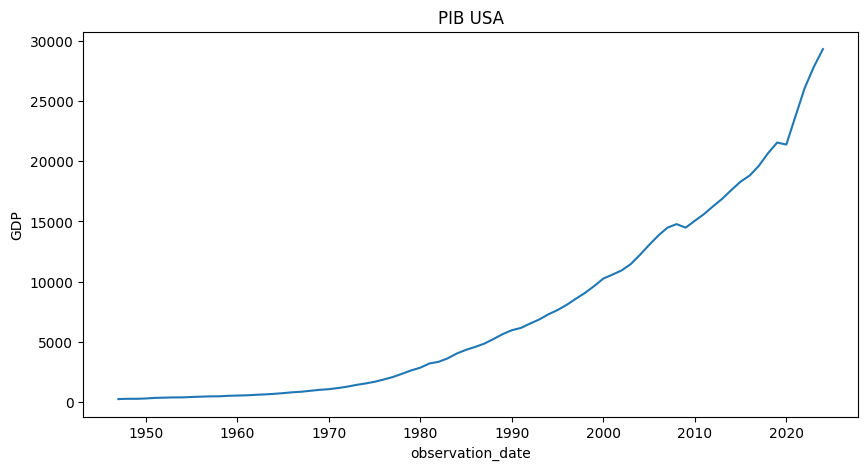

In [2015]:
plt.figure(figsize=(10, 5))
sns.lineplot(gdp.set_index("observation_date")["GDP"])
plt.title("PIB USA")
plt.show()

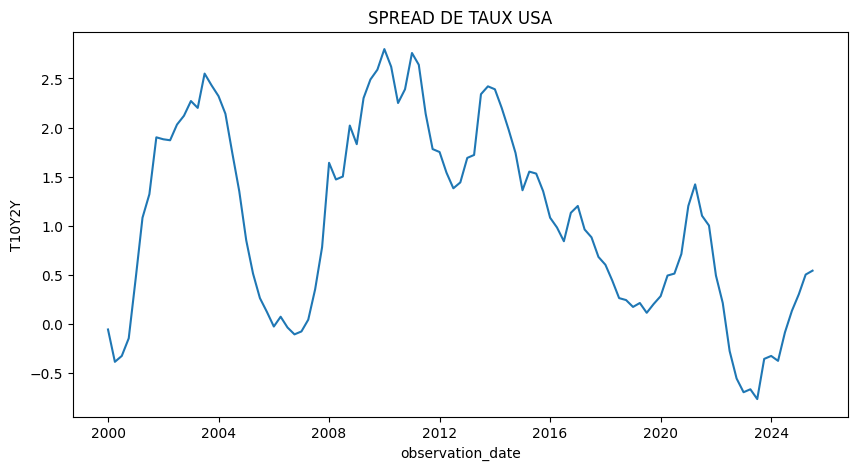

In [2016]:
plt.figure(figsize=(10, 5))
sns.lineplot(spread.set_index("observation_date")["T10Y2Y"])
plt.title("SPREAD DE TAUX USA")
plt.show()

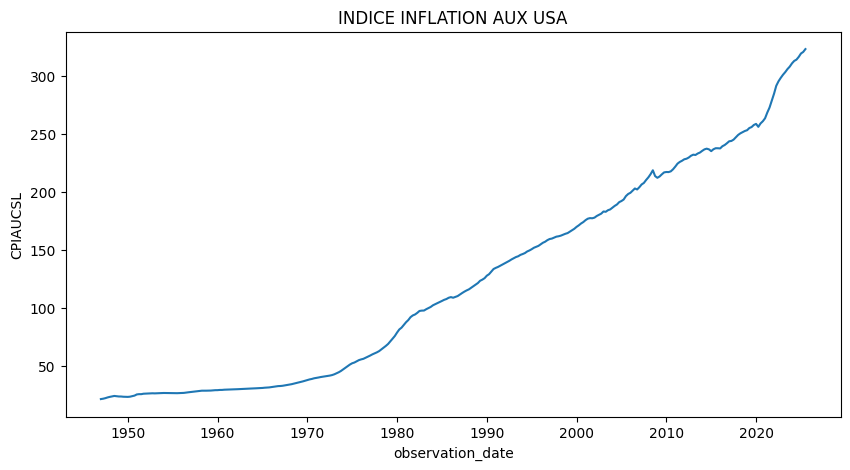

In [2017]:
plt.figure(figsize=(10, 5))
sns.lineplot(inflation.set_index("observation_date")["CPIAUCSL"])
plt.title("INDICE INFLATION AUX USA")
plt.show()

In [2018]:
gdp["year"] = gdp.observation_date.dt.year
gdp["Croissance_PIB"] = gdp["GDP"].pct_change() # Variation p/r année précédente
gdp["Croissance_PIB_lag1"] = gdp["Croissance_PIB"].shift(1)
gdp = gdp[["year", "Croissance_PIB_lag1"]]

/var/folders/48/gm8qnf514r3bs39xcscgqymr0000gn/T/ipykernel_87098/2599296831.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  gdp["Croissance_PIB"] = gdp["GDP"].pct_change() # Variation p/r année précédente


In [2019]:
spread["Year_Quarter"] = spread.observation_date.dt.to_period('Q')
spread["variation_spread"] = spread["T10Y2Y"].pct_change() # variation p/r trimestre pré
spread["T10Y2Y_variation_Lag1"] = spread["variation_spread"].shift(1)
spread["T10Y2Y_variation_Lag2"] = spread["variation_spread"].shift(2)
spread["T10Y2Y_Lag1"] = spread["T10Y2Y"].shift(1)
spread["T10Y2Y_Lag2"] = spread["T10Y2Y"].shift(2)
spread = spread[["Year_Quarter", "T10Y2Y_variation_Lag1", "T10Y2Y_variation_Lag2", "T10Y2Y_Lag1", "T10Y2Y_Lag2"]]

In [2020]:
inflation["Year_Quarter"] = inflation.observation_date.dt.to_period('Q')
inflation["variation_inflation_trimestre"] = inflation["CPIAUCSL"].pct_change(1) # variation p/r trimestre pré
inflation["variation_inflation_annee"] = inflation["CPIAUCSL"].pct_change(4) # variation p/r trimestre pré
inflation["Inflation_variation_Lag1_Trimestre"] = inflation["variation_inflation_trimestre"].shift(1)
inflation["Inflation_variation_Lag2_Trimestre"] = inflation["variation_inflation_trimestre"].shift(2)
inflation["Inflation_variation_Lag1_Annee"] = inflation["variation_inflation_annee"].shift(1)
inflation["Inflation_variation_Lag2_Annee"] = inflation["variation_inflation_annee"].shift(2)
inflation = inflation[["Year_Quarter", "Inflation_variation_Lag1_Trimestre","Inflation_variation_Lag2_Trimestre", "Inflation_variation_Lag1_Annee", "Inflation_variation_Lag2_Annee"]]

In [2021]:
df["Year_Quarter"] = df.ApprovalDate.dt.to_period('Q')
df = pd.merge(df, spread, how="left", on="Year_Quarter")
df = pd.merge(df, inflation, how = 'left', on = "Year_Quarter")
df = pd.merge(df, gdp, how="left", on="year")

In [2022]:
df = df.drop([col for col in df.columns if "_x" in col], axis =1)
df= df.drop([col for col in df.columns if "_y" in col], axis=1)

In [2023]:
df["diff_premier_paiement_vs_approval_date"] = (df["FirstDisbursementDate"]-df['ApprovalDate']).dt.days

In [2024]:
df.columns

Index(['ApprovalDate', 'BorrState', 'BankName', 'BankState', 'GrossApproval',
       'SBAGuaranteedApproval', 'ApprovalFY', 'FirstDisbursementDate',
       'ProcessingMethod', 'Subprogram', 'TerminMonths', 'NAICSCode',
       'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'BusinessType',
       'LoanStatus', 'RevolverStatus', 'JobsSupported', 'CollateralInd',
       'Industry', 'IndustryName', 'Log_GrossApproval',
       'Log_SBAGuaranteedApproval', 'TerminMonths_cut', 'JobsSupported_cut',
       'year_lag', 'emprunts_us_tot', 'emprunts_us_med', 'emprunts_us_mean',
       'year', 'emprunt_state_tot', 'emprunt_state_med', 'emprunt_state_mean',
       'emprunt_industry_tot', 'emprunt_industry_med', 'emprunt_industry_mean',
       'taille_emprunt_vs_state_med', 'taille_emprunt__vs_industry_med',
       'taille_emprunt_vs_us_med', 'delta_emprunt_vs_state_mean',
       'delta_emprunt_vs_industry_mean', 'part_emprunt_vs_state',
       'part_emprunt_vs_industry', 'taille_relative_state

In [2025]:
data = df.drop(columns={"ProcessingMethod",
                #"FirstDisbursementDate",
                "NAICSCode",
                "ProjectCounty",
                "Industry",
                "Year_Quarter", 
                "year", 
                "TerminMonths",
                        "year_lag", 'BankState',#"TerminMonths_cut",
                        "BankName", "BorrState"
                       })

In [2026]:
data.shape

(1049518, 47)

In [2027]:
data = data[data["ApprovalDate"] > "2022-01-01"]

In [2028]:
data.groupby([data["ApprovalDate"].dt.year])["LoanStatus"].value_counts()


ApprovalDate  LoanStatus
2022          0             7909
              1             1101
2023          0             4537
              1              685
2024          0             2175
              1              107
2025          0              200
Name: count, dtype: int64

In [2029]:
development = data[data["ApprovalDate"] < "2023-01-01"] # Pour la contruction de train/test
OOT = data[data["ApprovalDate"] >= "2023-01-01"] # Pour la validation temporelle du modèle out of time



In [2030]:
development = development.set_index("ApprovalDate")
OOT = OOT.set_index("ApprovalDate")

In [2031]:
development = development.drop([col for col in OOT.columns if "ApprovalFY" in col], axis=1)
OOT = OOT.drop([col for col in OOT.columns if "ApprovalFY" in col], axis=1)

In [2032]:
development.shape

(9010, 45)

In [2033]:
OOT.shape

(7704, 45)

In [2034]:
development.LoanStatus.value_counts(normalize=True )

LoanStatus
0    0.877802
1    0.122198
Name: proportion, dtype: float64

In [2035]:
OOT.LoanStatus.value_counts(normalize=True )

LoanStatus
0    0.897196
1    0.102804
Name: proportion, dtype: float64

In [2036]:
# 1. ON TRIE SUR L'INDEX (Crucial !)
# Pas de reset_index ici, sinon vous perdez vos dates !
development = development.sort_index()

# 2. On calcule le point de coupe (75%)
n = development.shape[0]
cut = int(n * 0.75)

# 3. On coupe (iloc fonctionne sur la position, peu importe l'index)
train = development.iloc[:cut]
test  = development.iloc[cut:]

# 4. VÉRIFICATION (Le "Sanity Check")
# On regarde directement l'index (.index.max())
print(f"--- Vérification Temporelle ---")
print(f"Fin du Train   : {train.index.max()}")
print(f"Début du Test  : {test.index.min()}")

# Vérifiez que les périodes ne se chevauchent pas
if train.index.max() <= test.index.min():
    print("✅ Le découpage est bien temporel (Pas de fuite).")
else:
    print("❌ ATTENTION : Les dates se chevauchent ! Le tri a échoué.")

--- Vérification Temporelle ---
Fin du Train   : 2022-09-14 00:00:00
Début du Test  : 2022-09-14 00:00:00
✅ Le découpage est bien temporel (Pas de fuite).


In [2037]:
train.LoanStatus.value_counts(normalize=True)

LoanStatus
0    0.88634
1    0.11366
Name: proportion, dtype: float64

In [2038]:
test.LoanStatus.value_counts(normalize=True)

LoanStatus
0    0.852197
1    0.147803
Name: proportion, dtype: float64

In [2039]:
X_train = train.drop("LoanStatus", axis=1)
X_test = test.drop("LoanStatus", axis=1)
y_train= train.LoanStatus
y_test = test.LoanStatus
X_oot = OOT.drop("LoanStatus", axis=1)
y_oot = OOT.LoanStatus


In [2040]:
X_train.select_dtypes("object").columns

Index(['Subprogram', 'ProjectState', 'SBADistrictOffice', 'BusinessType',
       'IndustryName'],
      dtype='object')

In [2041]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6757 entries, 2022-01-03 to 2022-09-14
Data columns (total 44 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   GrossApproval                           6757 non-null   float64       
 1   SBAGuaranteedApproval                   6757 non-null   float64       
 2   FirstDisbursementDate                   6757 non-null   datetime64[ns]
 3   Subprogram                              6757 non-null   object        
 4   ProjectState                            6757 non-null   object        
 5   SBADistrictOffice                       6757 non-null   object        
 6   BusinessType                            6757 non-null   object        
 7   RevolverStatus                          6757 non-null   int64         
 8   JobsSupported                           6757 non-null   float64       
 9   CollateralInd                     

In [2042]:
categorical_high_card = [
    'ProjectState', 
    'SBADistrictOffice', 
    'IndustryName'
]

categorical_low_card = [
    'Subprogram', 
    'BusinessType', 
    'RevolverStatus',      
    'CollateralInd',       
    'TerminMonths_cut',    
    'JobsSupported_cut'    
]

numeric_features = [
    'GrossApproval', 'SBAGuaranteedApproval', 
    'JobsSupported', 
    'emprunts_us_tot', 'emprunts_us_med', 'emprunts_us_mean',
    'emprunt_state_tot', 'emprunt_state_med', 'emprunt_state_mean',
    'emprunt_industry_tot', 'emprunt_industry_med', 'emprunt_industry_mean',
    'taille_emprunt_vs_state_med', 'taille_emprunt__vs_industry_med', 'taille_emprunt_vs_us_med',
    'delta_emprunt_vs_state_mean', 'delta_emprunt_vs_industry_mean',
    'part_emprunt_vs_state', 'part_emprunt_vs_industry',
    'taille_relative_state_vs_etat', 'taille_relative_industry_vs_etat',
    'ratio_loan_guarantee',
    'T10Y2Y_variation_Lag1', 'T10Y2Y_variation_Lag2', 'T10Y2Y_Lag1', 'T10Y2Y_Lag2',
    'Inflation_variation_Lag1_Trimestre', 'Inflation_variation_Lag2_Trimestre',
    'Inflation_variation_Lag1_Annee', 'Inflation_variation_Lag2_Annee',
    'Croissance_PIB_lag1',
    'diff_premier_paiement_vs_approval_date'
]

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_low_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))])

categorical_high_transformer = Pipeline(steps=[('target_enc', TargetEncoder(smoothing=10))])

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_low', categorical_low_transformer, categorical_low_card),
        ('cat_high', categorical_high_transformer, categorical_high_card)],
    verbose_feature_names_out=False 
).set_output(transform="pandas") 

X_train_encoded = preprocessor.fit_transform(X_train, y_train)
X_test_encoded  = preprocessor.transform(X_test)
X_oot_encoded   = preprocessor.transform(X_oot)

In [2043]:
X_train_encoded

,GrossApproval,SBAGuaranteedApproval,JobsSupported,emprunts_us_tot,emprunts_us_med,emprunts_us_mean,emprunt_state_tot,emprunt_state_med,emprunt_state_mean,emprunt_industry_tot,emprunt_industry_med,emprunt_industry_mean,taille_emprunt_vs_state_med,taille_emprunt__vs_industry_med,taille_emprunt_vs_us_med,delta_emprunt_vs_state_mean,delta_emprunt_vs_industry_mean,part_emprunt_vs_state,part_emprunt_vs_industry,taille_relative_state_vs_etat,taille_relative_industry_vs_etat,ratio_loan_guarantee,T10Y2Y_variation_Lag1,T10Y2Y_variation_Lag2,T10Y2Y_Lag1,T10Y2Y_Lag2,Inflation_variation_Lag1_Trimestre,Inflation_variation_Lag2_Trimestre,Inflation_variation_Lag1_Annee,Inflation_variation_Lag2_Annee,Croissance_PIB_lag1,diff_premier_paiement_vs_approval_date,Subprogram_Contract Guaranty,Subprogram_FA$TRK (Small Loan Express),Subprogram_Guaranty,"Subprogram_International Trade - Sec, 7(a) (16)",Subprogram_Revolving Line of Credit Exports - Sec. 7(a) (14),Subprogram_Seasonal Line of Credit,Subprogram_Small General Contractors - Sec. 7(a) (9),Subprogram_Standard Asset Based,BusinessType_INDIVIDUAL,BusinessType_PARTNERSHIP,RevolverStatus_1,CollateralInd_1,"TerminMonths_cut_(48, 68]","TerminMonths_cut_(68, 84]","TerminMonths_cut_(84, 120]","TerminMonths_cut_(120, 240]","TerminMonths_cut_(240, 600]","JobsSupported_cut_(2.0, 3.0]","JobsSupported_cut_(3.0, 8.0]","JobsSupported_cut_(8.0, 10.0]","JobsSupported_cut_(10.0, 20.0]","JobsSupported_cut_(20.0, 99999.0]",ProjectState,SBADistrictOffice,IndustryName
ApprovalDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-03,-0.382357,-0.425523,-0.516020,0.0,0.0,2.328306e-10,-0.440595,-0.292078,-0.319394,-0.887720,-1.688022,-1.342843,-0.326530,0.089848,-0.382357,-0.294847,-0.004510,-0.141503,-0.134691,-0.440595,-0.887720,-1.027957,1.292349,0.144393,1.222900,0.781644,-0.869905,-1.295456,-1.244408,-1.157055,0.0,0.330322,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066946,0.065966,0.217839
2022-01-03,-0.278462,-0.260261,0.012011,0.0,0.0,2.328306e-10,-0.382011,0.319490,0.234122,-0.328299,-1.119729,-1.145883,-0.308800,-0.035397,-0.278462,-0.348652,0.044813,-0.123556,-0.150728,-0.382011,-0.328299,0.743263,1.292349,0.144393,1.222900,0.781644,-0.869905,-1.295456,-1.244408,-1.157055,0.0,0.330322,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.156682,0.156682,0.090710
2022-01-03,-0.541117,-0.530549,-0.463217,0.0,0.0,2.328306e-10,-0.601906,-0.385342,-0.593414,-0.887720,-1.688022,-1.342843,-0.462116,-0.438744,-0.541117,-0.376698,-0.166088,-0.175955,-0.227005,-0.601906,-0.887720,-1.027957,1.292349,0.144393,1.222900,0.781644,-0.869905,-1.295456,-1.244408,-1.157055,0.0,-0.469684,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015269,0.015269,0.217839
2022-01-03,-0.342667,-0.323972,-0.463217,0.0,0.0,2.328306e-10,-0.331302,-1.108520,-1.269882,0.279298,1.027593,0.425932,-0.066759,-0.398068,-0.342667,0.018000,-0.470749,-0.140783,-0.195138,-0.331302,0.279298,0.743263,1.292349,0.144393,1.222900,0.781644,-0.869905,-1.295456,-1.244408,-1.157055,0.0,-0.533685,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102381,0.113636,0.079848
2022-01-03,1.233260,1.239841,-0.093595,0.0,0.0,2.328306e-10,-0.262386,1.893665,1.593900,-0.440667,-0.521939,-0.680005,0.152654,1.512464,1.233260,0.789253,1.449924,0.136028,0.389621,-0.262386,-0.440667,0.743263,1.292349,0.144393,1.222900,0.781644,-0.869905,-1.295456,-1.244408,-1.157055,0.0,0.106320,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.083916,0.083916,0.121643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-14,-0.161727,-0.144423,-0.304808,0.0,0.0,2.328306e-10,-0.593064,0.013706,-0.

In [2044]:
X_test_encoded

,GrossApproval,SBAGuaranteedApproval,JobsSupported,emprunts_us_tot,emprunts_us_med,emprunts_us_mean,emprunt_state_tot,emprunt_state_med,emprunt_state_mean,emprunt_industry_tot,emprunt_industry_med,emprunt_industry_mean,taille_emprunt_vs_state_med,taille_emprunt__vs_industry_med,taille_emprunt_vs_us_med,delta_emprunt_vs_state_mean,delta_emprunt_vs_industry_mean,part_emprunt_vs_state,part_emprunt_vs_industry,taille_relative_state_vs_etat,taille_relative_industry_vs_etat,ratio_loan_guarantee,T10Y2Y_variation_Lag1,T10Y2Y_variation_Lag2,T10Y2Y_Lag1,T10Y2Y_Lag2,Inflation_variation_Lag1_Trimestre,Inflation_variation_Lag2_Trimestre,Inflation_variation_Lag1_Annee,Inflation_variation_Lag2_Annee,Croissance_PIB_lag1,diff_premier_paiement_vs_approval_date,Subprogram_Contract Guaranty,Subprogram_FA$TRK (Small Loan Express),Subprogram_Guaranty,"Subprogram_International Trade - Sec, 7(a) (16)",Subprogram_Revolving Line of Credit Exports - Sec. 7(a) (14),Subprogram_Seasonal Line of Credit,Subprogram_Small General Contractors - Sec. 7(a) (9),Subprogram_Standard Asset Based,BusinessType_INDIVIDUAL,BusinessType_PARTNERSHIP,RevolverStatus_1,CollateralInd_1,"TerminMonths_cut_(48, 68]","TerminMonths_cut_(68, 84]","TerminMonths_cut_(84, 120]","TerminMonths_cut_(120, 240]","TerminMonths_cut_(240, 600]","JobsSupported_cut_(2.0, 3.0]","JobsSupported_cut_(3.0, 8.0]","JobsSupported_cut_(8.0, 10.0]","JobsSupported_cut_(10.0, 20.0]","JobsSupported_cut_(20.0, 99999.0]",ProjectState,SBADistrictOffice,IndustryName
ApprovalDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-09-14,-0.412708,-0.372623,0.223223,0.0,0.0,2.328306e-10,2.344906,1.236841,1.123562,2.074505,1.483801,1.814177,-0.420872,-0.452012,-0.412708,-0.739560,-0.939672,-0.179210,-0.226818,2.344906,2.074505,1.451752,-0.931743,-1.586292,-1.236681,-1.669200,1.636993,0.897269,1.174193,1.373489,0.0,1.418330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.145863,0.130682,0.098837
2022-09-14,0.809511,0.819349,6.718005,0.0,0.0,2.328306e-10,2.344906,1.236841,1.123562,-1.112813,0.141921,-0.035551,0.107342,0.603712,0.809511,0.495877,0.834062,-0.130615,0.953314,2.344906,-1.112813,0.743263,-0.931743,-1.586292,-1.236681,-1.669200,1.636993,0.897269,1.174193,1.373489,0.0,0.170321,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.145863,0.189076,0.124378
2022-09-14,0.013376,-0.163729,-0.146398,0.0,0.0,2.328306e-10,-0.624232,-0.903645,-0.565191,-0.299347,0.461266,1.039528,0.351854,-0.109758,0.013376,0.175693,-0.284141,0.015944,-0.061731,-0.624232,-0.299347,-1.027957,-0.931743,-1.586292,-1.236681,-1.669200,1.636993,0.897269,1.174193,1.373489,0.0,0.938326,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.050315,0.050000,0.109756
2022-09-14,0.139800,0.154787,1.332089,0.0,0.0,2.328306e-10,-0.736181,0.674811,0.597733,-0.328299,-1.119729,-1.145883,-0.112983,0.681940,0.139800,-0.030198,0.470499,0.159440,-0.017088,-0.736181,-0.328299,0.743263,-0.931743,-1.586292,-1.236681,-1.669200,1.636993,0.897269,1.174193,1.373489,0.0,-0.085681,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.199051,0.199051,0.090710
2022-09-15,-0.540767,-0.530318,-0.304808,0.0,0.0,2.328306e-10,-0.925290,-1.114636,-1.480133,1.017033,0.461266,0.229537,-0.433725,-0.514348,-0.540767,-0.121914,-0.616111,-0.139432,-0.239445,-0.925290,1.017033,-1.027957,-0.931743,-1.586292,-1.236681,-1.669200,1.636993,0.897269,1.174193,1.373489,0.0,0.490323,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.139945,0.139945,0.131579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30,1.659344,1.662649,0.012011,0.0,0.0,2.328306e-10,0.776512,0.721596,0.904208,0.279298,1.027593,0.4

In [2045]:
X_oot_encoded

,GrossApproval,SBAGuaranteedApproval,JobsSupported,emprunts_us_tot,emprunts_us_med,emprunts_us_mean,emprunt_state_tot,emprunt_state_med,emprunt_state_mean,emprunt_industry_tot,emprunt_industry_med,emprunt_industry_mean,taille_emprunt_vs_state_med,taille_emprunt__vs_industry_med,taille_emprunt_vs_us_med,delta_emprunt_vs_state_mean,delta_emprunt_vs_industry_mean,part_emprunt_vs_state,part_emprunt_vs_industry,taille_relative_state_vs_etat,taille_relative_industry_vs_etat,ratio_loan_guarantee,T10Y2Y_variation_Lag1,T10Y2Y_variation_Lag2,T10Y2Y_Lag1,T10Y2Y_Lag2,Inflation_variation_Lag1_Trimestre,Inflation_variation_Lag2_Trimestre,Inflation_variation_Lag1_Annee,Inflation_variation_Lag2_Annee,Croissance_PIB_lag1,diff_premier_paiement_vs_approval_date,Subprogram_Contract Guaranty,Subprogram_FA$TRK (Small Loan Express),Subprogram_Guaranty,"Subprogram_International Trade - Sec, 7(a) (16)",Subprogram_Revolving Line of Credit Exports - Sec. 7(a) (14),Subprogram_Seasonal Line of Credit,Subprogram_Small General Contractors - Sec. 7(a) (9),Subprogram_Standard Asset Based,BusinessType_INDIVIDUAL,BusinessType_PARTNERSHIP,RevolverStatus_1,CollateralInd_1,"TerminMonths_cut_(48, 68]","TerminMonths_cut_(68, 84]","TerminMonths_cut_(84, 120]","TerminMonths_cut_(120, 240]","TerminMonths_cut_(240, 600]","JobsSupported_cut_(2.0, 3.0]","JobsSupported_cut_(3.0, 8.0]","JobsSupported_cut_(8.0, 10.0]","JobsSupported_cut_(10.0, 20.0]","JobsSupported_cut_(20.0, 99999.0]",ProjectState,SBADistrictOffice,IndustryName
ApprovalDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-02,-0.541117,-0.530549,-0.410414,-6.101679e+09,-129000.0,-210536.587629,-0.721445,-0.964802,-0.820947,-1.483524,-0.875893,-1.249062,-0.443935,-0.494480,-0.516019,-0.311411,-0.192949,-0.172022,-0.110160,-0.317104,-1.362640,-1.027957,6.341639,-12.672326,-3.633995,-4.762889,-12.075239,-2.330766,-0.790431,1.617606,0.117603,-0.341683,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.156682,0.156682,0.135406
2023-01-02,-0.541117,-0.530549,-0.146398,-6.101679e+09,-129000.0,-210536.587629,-0.975182,-1.362321,-1.944089,-1.304007,-1.358058,-1.472779,-0.404897,-0.473084,-0.516019,0.010857,-0.128870,-0.076378,-0.200452,-0.925320,-0.932330,-1.027957,6.341639,-12.672326,-3.633995,-4.762889,-12.075239,-2.330766,-0.790431,1.617606,0.117603,0.106320,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.019351,0.019351,0.098214
2023-01-03,-0.541117,-0.530549,-0.568823,-6.101679e+09,-129000.0,-210536.587629,-0.666366,-1.209429,-1.580174,-1.020337,-1.111863,-1.256194,-0.425917,-0.486193,-0.516019,-0.093563,-0.190906,-0.174173,-0.222911,-0.185076,-0.252363,-1.027957,6.341639,-12.672326,-3.633995,-4.762889,-12.075239,-2.330766,-0.790431,1.617606,0.117603,-0.245682,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.202073,0.237864,0.121643
2023-01-03,-0.476912,-0.488075,-0.357611,-6.101679e+09,-129000.0,-210536.587629,-0.721445,-0.964802,-0.820947,-0.997493,-0.207314,0.107436,-0.344837,-0.445856,-0.396599,-0.246512,-0.516150,-0.142424,-0.179261,-0.317104,-0.197605,-1.027957,6.341639,-12.672326,-3.633995,-4.762889,-12.075239,-2.330766,-0.790431,1.617606,0.117603,-0.373683,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.156682,0.156682,0.109756
2023-01-03,-0.546954,-0.534410,-0.463217,-6.101679e+09,-129000.0,-210536.587629,-0.037930,0.090152,0.110659,-0.676109,-0.973427,-0.697708,-0.472836,-0.500314,-0.526875,-0.584621,-0.356815,-0.182274,-0.233612,1.321308,0.572765,-1.027957,6.341639,-12.672326,-3.633995,-4.762889,-12.075239,-2.330766,-0.790431,1.617606,0.117603,0.266321,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132937,0.176056,0.131579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### Régression logistique LASSO

In [2046]:
lasso_model = LogisticRegression(
    penalty='l1', 
    solver='liblinear', 
    max_iter=5000, 
    random_state=42,
    class_weight='balanced'
)

param_grid = {'C': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    lasso_model, 
    param_grid, 
    cv=tscv, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_encoded, y_train)
best_lasso = grid_search.best_estimator_
best_C = grid_search.best_params_['C']

print(f"\nMeilleur paramètre C trouvé : {best_C}")
print(f"Meilleur score CV (AUC) : {grid_search.best_score_:.4f}")

probs_train = best_lasso.predict_proba(X_train_encoded)[:, 1]
probs_test  = best_lasso.predict_proba(X_test_encoded)[:, 1]
probs_oot   = best_lasso.predict_proba(X_oot_encoded)[:, 1]

auc_train = roc_auc_score(y_train, probs_train)
auc_test  = roc_auc_score(y_test, probs_test)
auc_oot   = roc_auc_score(y_oot, probs_oot)

print(f"\n=== RÉSULTATS LASSO (C={best_C}) ===")
print(f"AUC Train : {auc_train:.4f}")
print(f"AUC Test  : {auc_test:.4f}")
print(f"AUC OOT   : {auc_oot:.4f}")

coeffs = best_lasso.coef_[0]
feature_names = X_train_encoded.columns

lasso_coefs = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coeffs,
    'Importance_Absolue': np.abs(coeffs)
})

survivors = lasso_coefs[lasso_coefs['Coefficient'] != 0].sort_values(by='Importance_Absolue', ascending=False)
eliminated = lasso_coefs[lasso_coefs['Coefficient'] == 0]

print(f"\n--- Bilan de la Sélection Lasso ---")
print(f"Variables initiales : {len(feature_names)}")
print(f"Variables conservées : {len(survivors)}")
print(f"Variables supprimées (Coeff=0) : {len(eliminated)}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Meilleur paramètre C trouvé : 0.1
Meilleur score CV (AUC) : 0.7729

=== RÉSULTATS LASSO (C=0.1) ===
AUC Train : 0.8124
AUC Test  : 0.8115
AUC OOT   : 0.7808

--- Bilan de la Sélection Lasso ---
Variables initiales : 57
Variables conservées : 28
Variables supprimées (Coeff=0) : 29


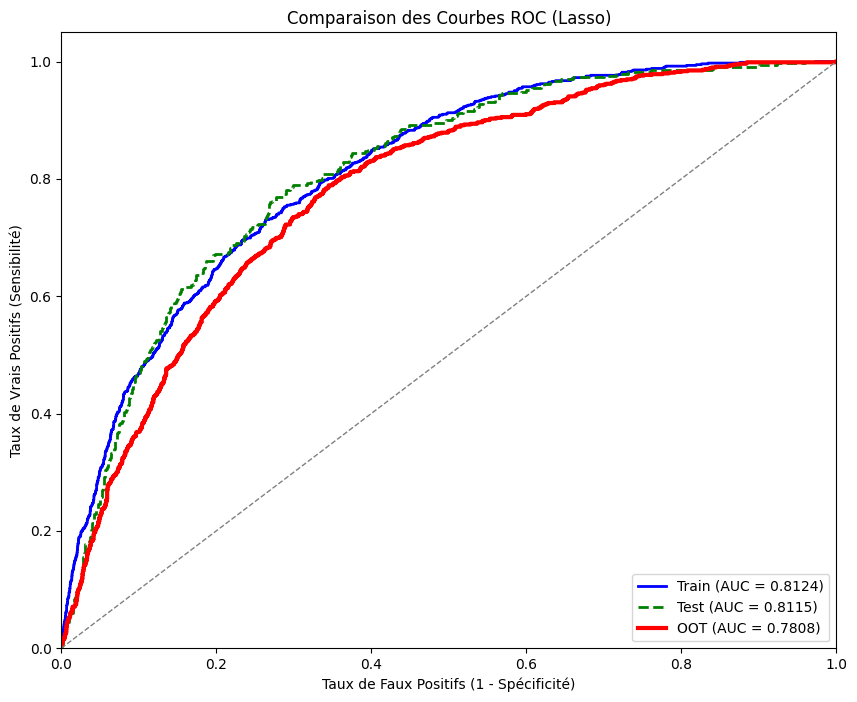

In [2047]:
fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)
fpr_oot, tpr_oot, _ = roc_curve(y_oot, probs_oot)
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train (AUC = {auc_train:.4f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, linestyle='--', label=f'Test (AUC = {auc_test:.4f})')
plt.plot(fpr_oot, tpr_oot, color='red', lw=3, label=f'OOT (AUC = {auc_oot:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Comparaison des Courbes ROC (Lasso)')
plt.legend(loc="lower right")
plt.grid(alpha=0)

In [2048]:
coeffs = best_lasso.coef_[0]
feature_names = X_train_encoded.columns

scorecard = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coeffs,
    'Importance': np.abs(coeffs)
})

scorecard = scorecard[scorecard['Coefficient'] != 0].sort_values(by='Importance', ascending=False)
scorecard['Odds_Ratio'] = np.exp(scorecard['Coefficient'])

print("--- VARIABLES DU MODÈLE FINAL ---")
display(scorecard)

--- VARIABLES DU MODÈLE FINAL ---


,Variable,Coefficient,Importance,Odds_Ratio
55,SBADistrictOffice,6.089151,6.089151,441.046760
56,IndustryName,4.001691,4.001691,54.690562
48,"TerminMonths_cut_(240, 600]",-3.622620,3.622620,0.026713
47,"TerminMonths_cut_(120, 240]",-1.792890,1.792890,0.166478
45,"TerminMonths_cut_(68, 84]",-1.148945,1.148945,0.316971
43,CollateralInd_1,-0.868841,0.868841,0.419438
44,"TerminMonths_cut_(48, 68]",-0.626152,0.626152,0.534645
46,"TerminMonths_cut_(84, 120]",-0.558292,0.558292,0.572186
21,ratio_loan_guarantee,0.417182,0.417182,1.517679
15,delta_emprunt_vs_state_mean,-0.380751,0.380751,0.683348


In [2049]:
def calculate_gini(auc_score):
    """
    Convertit l'AUC en coefficient de Gini.
    Formule : 2 * AUC - 1
    """
    return 2 * auc_score - 1


def relative_gini(gini_train, gini_test):
    """
    Calcule le pourcentage de perte de performance (Overfitting Gap).
    
    Formule : (Train - Test) / Train
    """
    if gini_train == 0:
        return 0
    return (gini_train - gini_test) / gini_train

In [2050]:
gini_train = calculate_gini(auc_train)
gini_test = calculate_gini(auc_test)
gini_oot = calculate_gini(auc_oot)    
drop1 = gini_drop(gini_train, gini_test)
drop2 = gini_drop(gini_train, gini_oot)

print("###################################################\n")
print(f"Gini train {gini_train}\n")
print("###################################################\n")
print(f"Gini test {gini_test}\n")
print("###################################################\n")
print(f"Gini oot {gini_oot}\n")
print("###################################################\n")
print(f"Perte de perf train test : {drop1:.2%}\n")
print("###################################################\n")
print(f"Perte de perf train oot : {drop2:.2%}\n")
print("###################################################\n")


###################################################

Gini train 0.6247332348889632

###################################################

Gini test 0.6229010260260264

###################################################

Gini oot 0.561620801475402

###################################################

Perte de perf train test : 0.29%

###################################################

Perte de perf train oot : 10.10%

###################################################

